# S12: Vedic Fractional Alpha — Option-Executed Research Notebook

**Strategy**: Anomalous diffusion detection via fractional calculus + Vedic mathematics, executed on ATM index options.

**Key innovations over base S12**:
1. Features computed from **1-minute bars** (not daily closes)
2. SANOS calibrated from **nfo_1min CE/PE** bars (316 days vs 125 from bhavcopy)
3. Trades executed on **actual ATM options** with prices from nfo_1min
4. **Walk-forward OOS validation** (Optuna with train/test splits)

**Self-contained**: No QuantLaxmi imports — all math reimplemented from first principles.

---

## Table of Contents

1. [Imports & Data Connection](#1)
2. [Data Exploration](#2)
3. [SANOS Mathematics](#3)
4. [SANOS Implementation](#4)
5. [Option Chain from 1-Min Bars](#5)
6. [SANOS Calibration (316 Days)](#6)
7. [SANOS Visualization](#7)
8. [Fractional Calculus Mathematics](#8)
9. [Fractional Features](#9)
10. [Mock Theta Mathematics](#10)
11. [Mock Theta Implementation](#11)
12. [Vedic Angular Mathematics](#12)
13. [Vedic Angular Implementation](#13)
14. [Timothy Masters Indicators](#14)
15. [Auxiliary Features](#15)
16. [Feature Pipeline](#16)
17. [Compute All Features](#17)
18. [Feature Visualization](#18)
19. [Signal Construction](#19)
20. [Optuna Walk-Forward Optimization](#20)
21. [Option Execution Mathematics](#21)
22. [Option Executor](#22)
23. [Run Full Backtest](#23)
24. [Equity Curves](#24)
25. [Trade-Level Analysis](#25)
26. [Validation Gates](#26)
27. [Validation Implementation](#27)
28. [Feature Importance](#28)
29. [Summary & References](#29)

In [1]:
"""Cell 1: Imports & Data Connection — zero QuantLaxmi imports."""
import warnings; warnings.filterwarnings("ignore")
import math, time, json, os
from dataclasses import dataclass, field
from datetime import date, timedelta
from functools import lru_cache

import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import linprog
from scipy.special import gamma as gamma_fn
from scipy.stats import spearmanr, f as f_dist

try:
    import torch
    HAS_GPU = torch.cuda.is_available()
    if HAS_GPU:
        DEVICE = torch.device("cuda")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
except ImportError:
    HAS_GPU = False

try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    HAS_OPTUNA = True
except ImportError:
    HAS_OPTUNA = False
    print("Optuna not available — walk-forward disabled")

# ── DuckDB connection to Hive-partitioned Parquet ──
DATA_ROOT = "/home/ubuntu/Desktop/7hills/QuantLaxmi/data/market"
con = duckdb.connect()
for cat in ["nfo_1min", "ticks", "instruments"]:
    cat_dir = os.path.join(DATA_ROOT, cat)
    if os.path.isdir(cat_dir):
        con.execute(
            f"CREATE VIEW {cat} AS SELECT * FROM read_parquet("
            f"'{cat_dir}/*/*.parquet', hive_partitioning=true, union_by_name=true)"
        )
# nse_index_close needs union_by_name for schema drift
cat_dir = os.path.join(DATA_ROOT, "nse_index_close")
if os.path.isdir(cat_dir):
    con.execute(
        f"CREATE VIEW nse_index_close AS SELECT * FROM read_parquet("
        f"'{cat_dir}/*/*.parquet', hive_partitioning=true, "
        f"hive_types_autocast=false, union_by_name=true)"
    )

# ── Configuration ──
SYMBOLS = ["NIFTY", "BANKNIFTY"]
INDEX_NAME_MAP = {"NIFTY": "Nifty 50", "BANKNIFTY": "Nifty Bank"}
STRIKE_STEP = {"NIFTY": 50, "BANKNIFTY": 100}
COST_BPS_FUTURES = 5.0
COST_BPS_OPTIONS = 10.0
np.random.seed(42)

print(f"DuckDB connected. DATA_ROOT={DATA_ROOT}")
print(f"Symbols: {SYMBOLS}")

GPU: Tesla T4
DuckDB connected. DATA_ROOT=/home/ubuntu/Desktop/7hills/QuantLaxmi/data/market
Symbols: ['NIFTY', 'BANKNIFTY']


<a id="2"></a>
## 2. Data Exploration

Query data availability across nfo_1min, ticks, and nse_index_close.

In [2]:
"""Cell 2: Data exploration — schema, date ranges, instrument counts."""
print("=" * 70)
print("DATA AVAILABILITY")
print("=" * 70)

# nfo_1min summary
df_summary = con.execute("""
    SELECT MIN(date) AS first_date, MAX(date) AS last_date,
           COUNT(DISTINCT date) AS n_days,
           COUNT(DISTINCT name) AS n_names
    FROM nfo_1min
""").fetchdf()
print(f"\nnfo_1min: {df_summary['n_days'].iloc[0]} days "
      f"({df_summary['first_date'].iloc[0]} → {df_summary['last_date'].iloc[0]})")

# Instrument types
print("\nInstrument types:")
print(con.execute("""
    SELECT instrument_type, COUNT(*) AS rows
    FROM nfo_1min GROUP BY instrument_type ORDER BY rows DESC
""").fetchdf().to_string(index=False))

# Per-symbol FUT bar counts
print("\nFUT bars per symbol:")
print(con.execute("""
    SELECT name, COUNT(DISTINCT date) AS days, COUNT(*) AS bars
    FROM nfo_1min WHERE instrument_type = 'FUT'
    GROUP BY name ORDER BY days DESC LIMIT 10
""").fetchdf().to_string(index=False))

# CE/PE availability for NIFTY
print("\nNIFTY CE/PE daily strike counts (sample):")
print(con.execute("""
    SELECT date, instrument_type, COUNT(DISTINCT strike) AS n_strikes
    FROM nfo_1min
    WHERE name = 'NIFTY' AND instrument_type IN ('CE', 'PE')
    GROUP BY date, instrument_type
    ORDER BY date DESC LIMIT 10
""").fetchdf().to_string(index=False))

# nse_index_close
idx_summary = con.execute("""
    SELECT COUNT(DISTINCT date) AS n_days,
           COUNT(DISTINCT "Index Name") AS n_indices
    FROM nse_index_close
""").fetchdf()
print(f"\nnse_index_close: {idx_summary['n_days'].iloc[0]} days, "
      f"{idx_summary['n_indices'].iloc[0]} indices")

# Available dates for our symbols
all_dates = {}
for sym in SYMBOLS:
    dates_df = con.execute(
        "SELECT DISTINCT date FROM nfo_1min "
        "WHERE name = ? AND instrument_type = 'FUT' ORDER BY date",
        [sym]
    ).fetchdf()
    all_dates[sym] = sorted(dates_df["date"].tolist())
    print(f"\n{sym} FUT: {len(all_dates[sym])} days")

# Use intersection of dates across symbols
common_dates = sorted(set(all_dates[SYMBOLS[0]]) & set(all_dates[SYMBOLS[1]]))
print(f"\nCommon trading dates: {len(common_dates)} "
      f"({common_dates[0]} → {common_dates[-1]})")

DATA AVAILABILITY

nfo_1min: 316 days (2024-10-29 00:00:00 → 2026-02-06 00:00:00)

Instrument types:


instrument_type     rows
             PE 85752665
             CE 82122203
            FUT  1527539

FUT bars per symbol:


      name  days   bars
MIDCPNIFTY   316 345136
     NIFTY   316 354515
 BANKNIFTY   316 354502
NIFTYNXT50   316 248314
  FINNIFTY   316 225072

NIFTY CE/PE daily strike counts (sample):


      date instrument_type  n_strikes
2026-02-06              PE        112
2026-02-06              CE        111
2026-02-05              CE        111
2026-02-05              PE        111
2026-02-04              PE        111
2026-02-04              CE        112
2026-02-03              CE        112
2026-02-03              PE        113
2026-02-02              CE        112
2026-02-02              PE        111

nse_index_close: 125 days, 145 indices

NIFTY FUT: 316 days

BANKNIFTY FUT: 316 days

Common trading dates: 316 (2024-10-29 00:00:00 → 2026-02-06 00:00:00)


<a id="3"></a>
## 3. SANOS Mathematics

**SANOS** (Smooth strictly Arbitrage-free Non-parametric Option Surfaces) from Buehler et al. (2026).

Option prices are convex combinations of Black-Scholes calls anchored at model strikes,
with martingale density weights found via linear programming.

### Black-Scholes Call (normalised)
$$C(K, v) = \Phi(d_1) - K \cdot \Phi(d_2), \quad d_{1,2} = \frac{-\ln K \pm v/2}{\sqrt{v}}$$
where $v = \sigma^2 T$ (total variance), $K$ is normalised strike $K/F$.

### LP Formulation
Decision variables: discrete densities $q_j \in \mathbb{R}^N$ for each expiry $j$.

**Objective**: minimise weighted L1 fitting error
$$\min \sum_j \sum_\ell w_{j\ell} |C^{\text{model}}_{j\ell} - C^{\text{market}}_{j\ell}|$$

**Constraints**:
1. **Normalisation**: $\mathbf{1}^\top q_j = 1$ (sum to 1 — discrete probabilities)
2. **Martingale**: $K^\top q_j = 1$ (unit forward — no-arbitrage)
3. **Calendar**: $U_j q_j \geq R_j q_{j-1}$ (option prices increase with maturity)
4. **Non-negativity**: $q_j \geq 0$

### ATM Variance (Brenner-Subrahmanyam)
$$\sigma^2 T \approx \left(\frac{\text{Straddle}}{2F} \cdot \sqrt{2\pi}\right)^2$$

### Density Extraction (Breeden-Litzenberger)
$$q(K) = e^{rT} \frac{\partial^2 C}{\partial K^2}$$
Moments: $\mu, \sigma^2, \text{skew}, \text{kurt}$ from discrete density.

In [3]:
"""Cell 4: SANOS implementation — LP solver from first principles."""

def bs_call(K: np.ndarray, k_strike: float, v: float) -> np.ndarray:
    """Black-Scholes call price in normalised coordinates (F=1).

    Parameters
    ----------
    K : model strike grid (normalised by forward)
    k_strike : market strike (normalised)
    v : η × σ²T (smoothed total variance)

    Returns C(K_i, k_strike, v) for each model strike K_i.
    """
    sqrt_v = np.sqrt(np.maximum(v, 1e-12))
    log_ratio = np.log(np.maximum(K / k_strike, 1e-30))
    d1 = (log_ratio + 0.5 * v) / sqrt_v
    d2 = d1 - sqrt_v
    from scipy.stats import norm
    return K * norm.cdf(d1) - k_strike * norm.cdf(d2)


@dataclass
class SANOSResult:
    """Result of SANOS calibration."""
    densities: list          # q_j arrays (discrete weights, sum to 1)
    model_strikes: np.ndarray
    variances: np.ndarray    # ATM variances per expiry
    eta: float
    expiry_labels: list
    market_strikes: list
    market_mids: list
    fit_errors: list
    max_fit_error: float
    lp_success: bool

    def density(self, expiry_idx: int, K_eval: np.ndarray) -> np.ndarray:
        """Interpolate density onto evaluation grid."""
        return np.interp(K_eval, self.model_strikes, self.densities[expiry_idx])


def fit_sanos(
    market_strikes: list[np.ndarray],
    market_calls: list[np.ndarray],
    atm_variances: np.ndarray | None = None,
    market_spreads: list | None = None,
    eta: float = 0.50,
    K_min: float = 0.70,
    K_max: float = 1.35,
    n_model_strikes: int = 80,
    expiry_labels: list | None = None,
) -> SANOSResult:
    """Fit SANOS surface via LP. Reimplemented from core/pricing/sanos.py."""
    M = len(market_strikes)
    if expiry_labels is None:
        expiry_labels = [f"T{j}" for j in range(M)]

    K_model = np.linspace(K_min, K_max, n_model_strikes)
    N = len(K_model)

    # Estimate ATM variances if not provided
    if atm_variances is None:
        atm_variances = np.zeros(M)
        for j in range(M):
            atm_idx = np.argmin(np.abs(market_strikes[j] - 1.0))
            c_atm = market_calls[j][atm_idx]
            atm_variances[j] = max((c_atm * math.sqrt(2.0 * math.pi)) ** 2, 1e-6)

    # Ensure variances increasing (no calendar arb)
    for j in range(1, M):
        atm_variances[j] = max(atm_variances[j], atm_variances[j - 1] + 1e-8)

    # Build LP
    total_market = sum(len(mk) for mk in market_strikes)
    total_vars = M * N
    n_extended = total_vars + 2 * total_market

    c_obj = np.zeros(n_extended)
    slack_offset = total_vars
    for j in range(M):
        n_j = len(market_strikes[j])
        offset = sum(len(market_strikes[jj]) for jj in range(j))
        for l in range(n_j):
            w = 1.0
            if market_spreads and market_spreads[j] is not None:
                spread = max(market_spreads[j][l], 1e-8)
                w = 1.0 / spread
            c_obj[slack_offset + offset + l] = w
            c_obj[slack_offset + total_market + offset + l] = w

    A_eq_rows, b_eq_rows = [], []
    A_ub_rows, b_ub_rows = [], []

    for j in range(M):
        q_start = j * N
        v_j = eta * atm_variances[j]

        # Sum to 1
        row = np.zeros(n_extended); row[q_start:q_start + N] = 1.0
        A_eq_rows.append(row); b_eq_rows.append(1.0)

        # Martingale: K' · q = 1
        row = np.zeros(n_extended); row[q_start:q_start + N] = K_model
        A_eq_rows.append(row); b_eq_rows.append(1.0)

        # Fitting: model_price - s+ + s- = market_mid
        n_j = len(market_strikes[j])
        offset = sum(len(market_strikes[jj]) for jj in range(j))
        for l in range(n_j):
            row = np.zeros(n_extended)
            k_mkt = market_strikes[j][l]
            row[q_start:q_start + N] = bs_call(K_model, k_mkt, v_j)
            row[slack_offset + offset + l] = -1.0
            row[slack_offset + total_market + offset + l] = 1.0
            A_eq_rows.append(row); b_eq_rows.append(market_calls[j][l])

    # Calendar arbitrage constraints
    for j in range(1, M):
        v_j = eta * atm_variances[j]
        v_prev = eta * atm_variances[j - 1]
        q_start_j = j * N
        q_start_prev = (j - 1) * N
        for l in range(N):
            row = np.zeros(n_extended)
            k_l = K_model[l]
            row[q_start_prev:q_start_prev + N] = bs_call(K_model, k_l, v_prev)
            row[q_start_j:q_start_j + N] = -bs_call(K_model, k_l, v_j)
            A_ub_rows.append(row); b_ub_rows.append(0.0)

    bounds = [(0, None)] * n_extended
    A_eq = np.array(A_eq_rows) if A_eq_rows else None
    b_eq = np.array(b_eq_rows) if b_eq_rows else None
    A_ub = np.array(A_ub_rows) if A_ub_rows else None
    b_ub = np.array(b_ub_rows) if b_ub_rows else None

    result = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                     bounds=bounds, method="highs",
                     options={"presolve": True, "time_limit": 60,
                              "dual_feasibility_tolerance": 1e-10,
                              "primal_feasibility_tolerance": 1e-10})

    densities, fit_errors_list = [], []
    max_error = 0.0

    if result.success:
        x = result.x
        for j in range(M):
            densities.append(x[j * N:(j + 1) * N])
    else:
        for j in range(M):
            q_j = np.zeros(N); q_j[N // 2] = 1.0
            densities.append(q_j)

    for j in range(M):
        v_j = eta * atm_variances[j]
        n_j = len(market_strikes[j])
        model_prices = np.array([
            np.dot(densities[j], bs_call(K_model, market_strikes[j][l], v_j))
            for l in range(n_j)
        ])
        errors = model_prices - market_calls[j]
        fit_errors_list.append(errors)
        max_error = max(max_error, np.max(np.abs(errors)))

    return SANOSResult(
        densities=densities, model_strikes=K_model, variances=atm_variances,
        eta=eta, expiry_labels=expiry_labels, market_strikes=market_strikes,
        market_mids=market_calls, fit_errors=fit_errors_list,
        max_fit_error=max_error, lp_success=result.success,
    )


def extract_density(result: SANOSResult, expiry_idx: int = 0,
                    n_points: int = 500, K_lo: float = 0.80, K_hi: float = 1.25):
    """Extract risk-neutral density from SANOS surface."""
    K = np.linspace(K_lo, K_hi, n_points)
    q = result.density(expiry_idx, K)
    q = np.maximum(q, 0.0)
    dK = K[1] - K[0]
    total = np.sum(q) * dK
    if total > 1e-12:
        q /= total
    return K, q


def compute_moments(K, q):
    """Mean, variance, skewness, excess kurtosis from density."""
    dK = K[1] - K[0]
    mu = float(np.sum(K * q) * dK)
    var = float(np.sum((K - mu) ** 2 * q) * dK)
    if var < 1e-14:
        return mu, var, 0.0, 0.0
    std = math.sqrt(var)
    z = (K - mu) / std
    skew = float(np.sum(z ** 3 * q) * dK)
    kurt = float(np.sum(z ** 4 * q) * dK) - 3.0
    return mu, var, skew, kurt


def shannon_entropy(q, dK):
    """Shannon entropy H = -∫ q ln q dK."""
    mask = q > 1e-15
    if not np.any(mask):
        return 0.0
    return float(-np.sum(q[mask] * np.log(q[mask])) * dK)


def kl_divergence(q_new, q_old, dK):
    """KL divergence D_KL(q_new ‖ q_old)."""
    eps = 1e-15
    qn = np.maximum(q_new, eps)
    qo = np.maximum(q_old, eps)
    return float(np.sum(qn * np.log(qn / qo)) * dK)


def tail_weights(K, q, mu, std):
    """P(K < μ-σ), P(K > μ+σ)."""
    dK = K[1] - K[0]
    left = float(np.sum(q[K < mu - std]) * dK)
    right = float(np.sum(q[K > mu + std]) * dK)
    return left, right

print(f"SANOS solver ready (linprog/highs)")

SANOS solver ready (linprog/highs)


<a id="5"></a>
## 5. Option Chain from 1-Min Bars

**Key innovation**: Build SANOS-ready option chain from nfo_1min EOD snapshots
instead of nse_fo_bhavcopy. This extends SANOS coverage from ~125 days to 316 days.

Steps per date:
1. Query last close per (strike, instrument_type, expiry) from nfo_1min
2. Pivot CE/PE → compute implied forward via put-call parity
3. Select OTM options, normalise by forward
4. Estimate ATM variance from straddle (Brenner-Subrahmanyam)

In [4]:
"""Cell 5: Option chain builder from nfo_1min."""

def prepare_chain_from_1min(con, symbol: str, d: str, max_expiries: int = 2):
    """Build SANOS-ready option chain from nfo_1min last-bar snapshot.

    Returns dict matching fit_sanos() input format, or None if insufficient data.
    """
    # EOD snapshot: last close per (strike, instrument_type, expiry)
    df = con.execute("""
        SELECT strike, instrument_type, expiry,
               LAST(close) AS close,
               LAST(oi) AS oi
        FROM nfo_1min
        WHERE date = ? AND name = ? AND instrument_type IN ('CE', 'PE')
        GROUP BY strike, instrument_type, expiry
        ORDER BY expiry, strike
    """, [d, symbol]).fetchdf()

    if df is None or len(df) < 20:
        return None

    # Get spot from index close (or approximate from futures)
    try:
        idx_name = INDEX_NAME_MAP.get(symbol, symbol)
        spot_df = con.execute(
            'SELECT "Closing Index Value" AS spot FROM nse_index_close '
            'WHERE "Index Name" = ? AND date = ?', [idx_name, d]
        ).fetchdf()
        if not spot_df.empty and spot_df["spot"].iloc[0] is not None:
            spot = float(spot_df["spot"].iloc[0])
        else:
            # Fallback: use FUT close
            fut_df = con.execute(
                "SELECT LAST(close) AS c FROM nfo_1min "
                "WHERE name = ? AND date = ? AND instrument_type = 'FUT' "
                "AND expiry = (SELECT MIN(expiry) FROM nfo_1min "
                "WHERE name = ? AND date = ? AND instrument_type = 'FUT')",
                [symbol, d, symbol, d]
            ).fetchdf()
            if fut_df.empty:
                return None
            spot = float(fut_df["c"].iloc[0])
    except Exception:
        return None

    # Select up to max_expiries
    expiries = sorted(df["expiry"].unique())[:max_expiries]

    market_strikes_list = []
    market_calls_list = []
    atm_vars = []
    expiry_labels = []

    for exp in expiries:
        sub = df[df["expiry"] == exp].copy()
        calls = sub[sub["instrument_type"] == "CE"].set_index("strike")["close"]
        puts = sub[sub["instrument_type"] == "PE"].set_index("strike")["close"]

        common = sorted(set(calls.index) & set(puts.index))
        if len(common) < 10:
            continue

        # Implied forward from put-call parity: F = K + C - P
        best_F, best_diff = spot, float("inf")
        for K in common:
            C, P = float(calls[K]), float(puts[K])
            if C <= 0 or P <= 0:
                continue
            F = K + C - P
            diff = abs(C - P)
            if diff < best_diff:
                best_diff = diff
                best_F = F
        forward = best_F

        # OTM options only: calls K >= F, puts K <= F → convert to call prices
        rows = []
        for K in common:
            C_val = float(calls[K])
            P_val = float(puts[K])
            k_norm = K / forward
            if K >= forward:
                # OTM call
                c_norm = C_val / forward
                if c_norm > 0.001:
                    rows.append((k_norm, c_norm))
            else:
                # OTM put → synthetic call: C = P + 1 - K/F
                c_norm = P_val / forward + 1.0 - k_norm
                if c_norm > 0.001:
                    rows.append((k_norm, c_norm))

        if len(rows) < 5:
            continue

        rows.sort(key=lambda x: x[0])
        k_arr = np.array([r[0] for r in rows])
        c_arr = np.array([r[1] for r in rows])

        # ATM variance from straddle (Brenner-Subrahmanyam)
        atm_K = min(common, key=lambda K: abs(K - forward))
        straddle = float(calls[atm_K]) + float(puts[atm_K])
        straddle_norm = straddle / forward
        atm_var = max((straddle_norm / 2.0 * math.sqrt(2.0 * math.pi)) ** 2, 1e-6)

        market_strikes_list.append(k_arr)
        market_calls_list.append(c_arr)
        atm_vars.append(atm_var)
        expiry_labels.append(str(exp))

    if not market_strikes_list:
        return None

    return {
        "market_strikes": market_strikes_list,
        "market_calls": market_calls_list,
        "atm_variances": np.array(atm_vars),
        "expiry_labels": expiry_labels,
        "forward": forward,
        "spot": spot,
    }

print("Option chain builder ready")

Option chain builder ready


<a id="6"></a>
## 6. SANOS Calibration (316 Days)

Loop over all trading dates, build option chains from nfo_1min, calibrate SANOS.
Cache results: skew, left_tail, entropy, KL divergence per day.

In [5]:
"""Cell 6: SANOS calibration over all trading dates."""

def calibrate_sanos_all_dates(con, symbol, dates):
    """Calibrate SANOS for each date, return cache dict."""
    cache = {}
    prev_density = None
    prev_K = None
    ok_count = 0
    fail_count = 0
    t0 = time.time()

    for i, d in enumerate(dates):
        chain = prepare_chain_from_1min(con, symbol, d, max_expiries=2)
        if chain is None:
            fail_count += 1
            continue

        try:
            result = fit_sanos(
                market_strikes=chain["market_strikes"],
                market_calls=chain["market_calls"],
                atm_variances=chain["atm_variances"],
                expiry_labels=chain["expiry_labels"],
                eta=0.50, n_model_strikes=80,
            )
        except Exception:
            fail_count += 1
            continue

        if not result.lp_success:
            fail_count += 1
            continue

        K, q = extract_density(result, 0)
        dK = K[1] - K[0]
        mu, var, skew, kurt = compute_moments(K, q)
        std = math.sqrt(max(var, 1e-14))
        H = shannon_entropy(q, dK)
        lt, rt = tail_weights(K, q, mu, std)

        # KL divergence from previous day
        kl = 0.0
        if prev_density is not None and prev_K is not None:
            # Interpolate prev density onto current grid
            prev_q_interp = np.interp(K, prev_K, prev_density)
            prev_q_interp = np.maximum(prev_q_interp, 0)
            total_prev = np.sum(prev_q_interp) * dK
            if total_prev > 1e-12:
                prev_q_interp /= total_prev
            kl = kl_divergence(q, prev_q_interp, dK)

        density_ok = var > 1e-8 and (np.sum(q) * dK) > 0.90

        cache[d] = {
            "skew": skew, "kurtosis": kurt, "left_tail": lt, "right_tail": rt,
            "entropy": H, "kl": kl, "density_ok": density_ok,
            "forward": chain["forward"], "spot": chain.get("spot", 0),
            "max_fit_error": result.max_fit_error,
        }

        prev_density = q
        prev_K = K
        ok_count += 1

        if (i + 1) % 50 == 0:
            elapsed = time.time() - t0
            print(f"  {symbol} {i+1}/{len(dates)} ({elapsed:.1f}s) — "
                  f"{ok_count} ok, {fail_count} fail")

    elapsed = time.time() - t0
    print(f"  {symbol} DONE: {ok_count}/{len(dates)} calibrated in {elapsed:.1f}s")
    return cache


# Run calibration for both symbols
sanos_cache = {}
for sym in SYMBOLS:
    dates_for_sym = con.execute(
        "SELECT DISTINCT CAST(date AS VARCHAR) AS date FROM nfo_1min "
        "WHERE name = ? AND instrument_type = 'CE' ORDER BY date", [sym]
    ).fetchdf()["date"].tolist()
    print(f"\nCalibrating SANOS for {sym} ({len(dates_for_sym)} dates)...")
    sanos_cache[sym] = calibrate_sanos_all_dates(con, sym, dates_for_sym)
    print(f"  Cached {len(sanos_cache[sym])} days")


Calibrating SANOS for NIFTY (316 dates)...


  NIFTY 50/316 (8.1s) — 50 ok, 0 fail


  NIFTY 100/316 (15.6s) — 100 ok, 0 fail


  NIFTY 150/316 (24.2s) — 150 ok, 0 fail


  NIFTY 200/316 (31.6s) — 200 ok, 0 fail


  NIFTY 250/316 (37.4s) — 250 ok, 0 fail


  NIFTY 300/316 (43.4s) — 300 ok, 0 fail


  NIFTY DONE: 316/316 calibrated in 45.5s
  Cached 316 days

Calibrating SANOS for BANKNIFTY (316 dates)...


  BANKNIFTY 50/316 (7.5s) — 50 ok, 0 fail


  BANKNIFTY 100/316 (15.1s) — 100 ok, 0 fail


  BANKNIFTY 150/316 (23.2s) — 150 ok, 0 fail


  BANKNIFTY 200/316 (30.0s) — 200 ok, 0 fail


  BANKNIFTY 250/316 (35.4s) — 250 ok, 0 fail


  BANKNIFTY 300/316 (41.0s) — 300 ok, 0 fail


  BANKNIFTY DONE: 316/316 calibrated in 43.0s
  Cached 316 days


<a id="7"></a>
## 7. SANOS Visualization

Density plots, skew/tail/entropy time series, IV smile comparison.

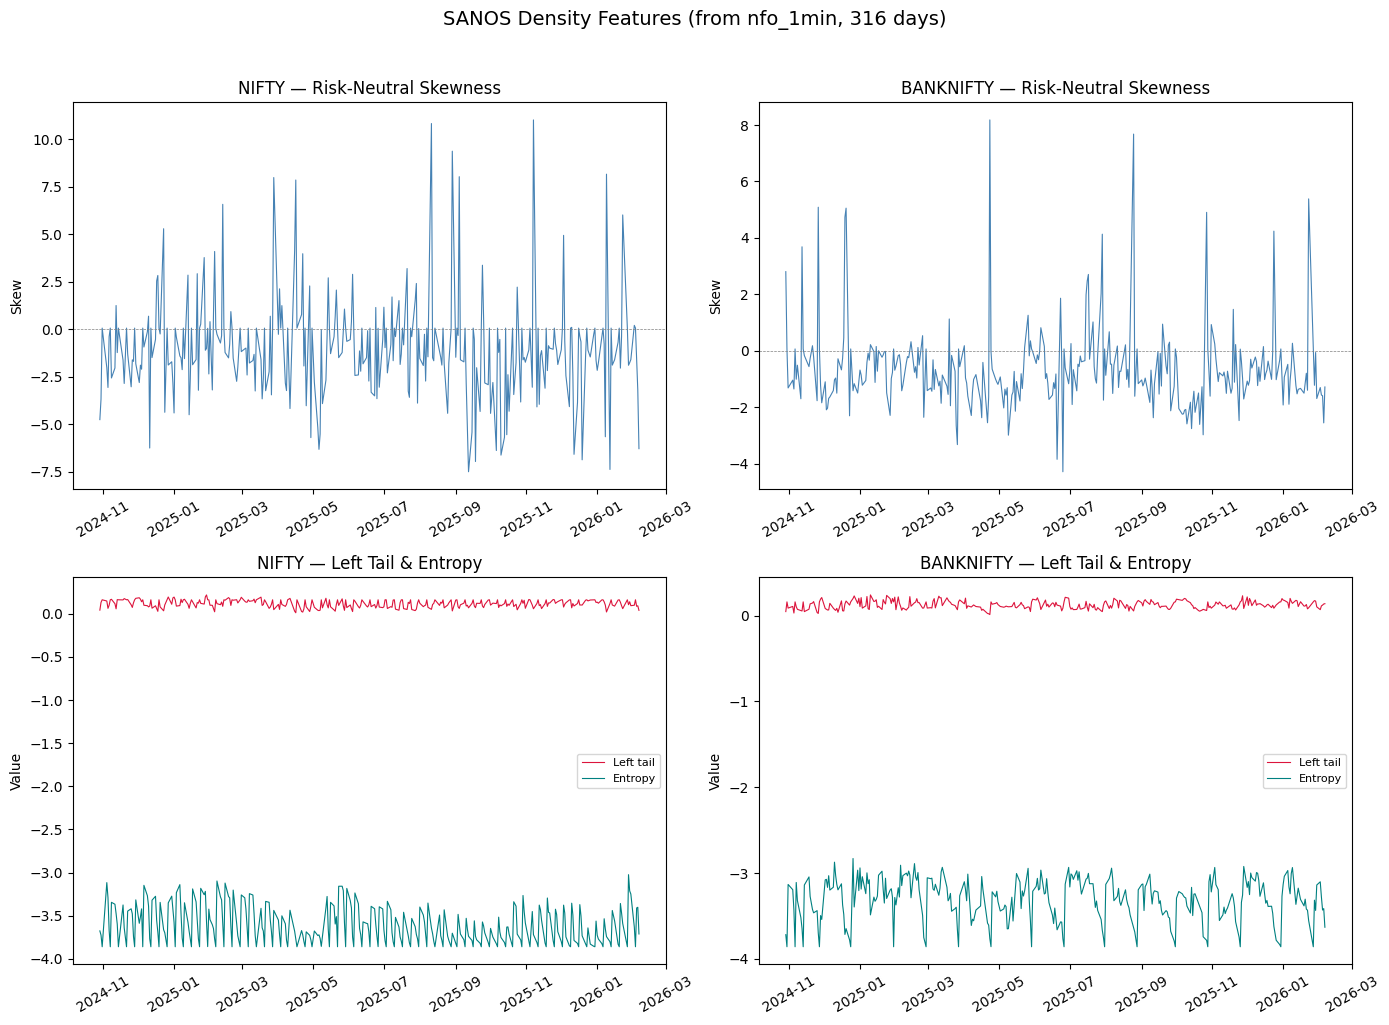


NIFTY: 316/316 good densities
  Skew: mean=-0.9647, std=2.6435
  Max fit error (median): 0.000157

BANKNIFTY: 316/316 good densities
  Skew: mean=-0.6367, std=1.4495
  Max fit error (median): 0.000642


In [6]:
"""Cell 7: SANOS visualisation."""

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, sym in enumerate(SYMBOLS):
    cache = sanos_cache[sym]
    if not cache:
        continue
    dates_sorted = sorted(cache.keys())
    skews = [cache[d]["skew"] for d in dates_sorted]
    lefts = [cache[d]["left_tail"] for d in dates_sorted]
    entropies = [cache[d]["entropy"] for d in dates_sorted]
    kls = [cache[d]["kl"] for d in dates_sorted]

    # Parse dates for x-axis
    from datetime import datetime
    date_objs = [datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d
                 for d in dates_sorted]

    ax = axes[0, idx]
    ax.plot(date_objs, skews, linewidth=0.8, color="steelblue")
    ax.axhline(0, color="gray", linewidth=0.5, linestyle="--")
    ax.set_title(f"{sym} — Risk-Neutral Skewness")
    ax.set_ylabel("Skew")
    ax.tick_params(axis="x", rotation=30)

    ax = axes[1, idx]
    ax.plot(date_objs, lefts, linewidth=0.8, color="crimson", label="Left tail")
    ax.plot(date_objs, entropies, linewidth=0.8, color="teal", label="Entropy")
    ax.set_title(f"{sym} — Left Tail & Entropy")
    ax.set_ylabel("Value")
    ax.legend(fontsize=8)
    ax.tick_params(axis="x", rotation=30)

plt.suptitle("SANOS Density Features (from nfo_1min, 316 days)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Summary stats
for sym in SYMBOLS:
    cache = sanos_cache[sym]
    n_ok = sum(1 for v in cache.values() if v["density_ok"])
    skews = [v["skew"] for v in cache.values() if v["density_ok"]]
    print(f"\n{sym}: {n_ok}/{len(cache)} good densities")
    if skews:
        print(f"  Skew: mean={np.mean(skews):.4f}, std={np.std(skews):.4f}")
        print(f"  Max fit error (median): {np.median([v['max_fit_error'] for v in cache.values()]):.6f}")

<a id="8"></a>
## 8. Fractional Calculus Mathematics

### Mittag-Leffler Function
$$E_{\alpha,\beta}(z) = \sum_{k=0}^{\infty} \frac{z^k}{\Gamma(\alpha k + \beta)}$$

Special cases: $E_{1,1}(z) = e^z$, $E_{2,1}(-z^2) = \cos(z)$.

### Mean Square Displacement (MSD) Scaling
$$\text{MSD}(\tau) = E[X^2(\tau)] \sim \tau^{2H}$$
- $H < 0.5$: subdiffusive (mean-reverting)
- $H = 0.5$: normal (Brownian)
- $H > 0.5$: superdiffusive (trending)

Fractional order: $\alpha = 2H$.

### Fractional Differencing (Hosking 1981)
Binomial expansion weights:
$$w_0 = 1, \quad w_k = -w_{k-1} \frac{d - k + 1}{k}$$

Optimal $d = 0.226$ preserves long memory while achieving stationarity.

### Fractional Fokker-Planck Equation (FFPE)
$$\partial_t^\alpha p = -\partial_x(f \cdot p) + D \, \partial_x^2 p$$

Time-stepping via Mittag-Leffler matrix exponential:
$$p_{n+1} = E_\alpha(-A \cdot \Delta t^\alpha) \cdot p_n$$

In [7]:
"""Cell 9: Fractional calculus features — from first principles."""

def mittag_leffler(z, alpha, beta=1.0, n_terms=100):
    """Generalised Mittag-Leffler function E_{α,β}(z)."""
    scalar = np.isscalar(z)
    z = np.atleast_1d(np.asarray(z, dtype=np.float64))
    result = np.zeros_like(z, dtype=np.float64)
    for k in range(n_terms):
        denom = gamma_fn(alpha * k + beta)
        if denom == 0 or np.isinf(denom):
            break
        term = z**k / denom
        result += term
        if np.all(np.abs(term) < 1e-15):
            break
    return float(result[0]) if scalar else result


def estimate_alpha_msd(returns, max_lag=50):
    """Estimate α via MSD scaling: MSD(τ) ~ τ^{2H}, α = 2H."""
    cumret = np.cumsum(returns)
    n = len(cumret)
    max_lag = min(max_lag, n // 3)
    if max_lag < 4:
        return 1.0

    lags = np.arange(2, max_lag + 1)
    msds = np.empty(len(lags))
    for i, tau in enumerate(lags):
        displacements = cumret[tau:] - cumret[:-tau]
        msds[i] = np.mean(displacements**2)

    valid = msds > 0
    if valid.sum() < 3:
        return 1.0
    log_lags = np.log(lags[valid])
    log_msds = np.log(msds[valid])
    slope, _ = np.polyfit(log_lags, log_msds, 1)
    hurst = np.clip(slope / 2.0, 0.01, 1.5)
    return float(2.0 * hurst)


def estimate_alpha_waiting(returns, threshold=0.0):
    """Estimate α from waiting-time distribution (Hill estimator)."""
    if threshold <= 0:
        threshold = np.std(returns, ddof=1) * 0.5 if len(returns) > 2 else 1e-8
    exceedance_idx = np.where(np.abs(returns) > threshold)[0]
    if len(exceedance_idx) < 10:
        return 1.0
    waiting_times = np.diff(exceedance_idx).astype(float)
    waiting_times = waiting_times[waiting_times > 0]
    if len(waiting_times) < 5:
        return 1.0
    sorted_wt = np.sort(waiting_times)[::-1]
    k = max(int(len(sorted_wt) * 0.1), 5)
    k = min(k, len(sorted_wt) - 1)
    log_ratios = np.log(sorted_wt[:k]) - np.log(sorted_wt[k])
    if np.sum(log_ratios) == 0:
        return 1.0
    return float(np.clip(k / np.sum(log_ratios), 0.1, 3.0))


def estimate_alpha(returns, max_lag=50):
    """Consensus α: 0.6 × MSD + 0.4 × waiting-time."""
    return 0.6 * estimate_alpha_msd(returns, max_lag) + 0.4 * estimate_alpha_waiting(returns)


def fractional_differentiation(series, d, threshold=1e-5, max_window=None):
    """Fractionally difference a series of order d (Hosking weights)."""
    n = len(series)
    if max_window is None:
        max_window = n
    weights = [1.0]
    k = 1
    while True:
        w = -weights[-1] * (d - k + 1) / k
        if abs(w) < threshold:
            break
        weights.append(w)
        k += 1
        if k > max_window:
            break
    weights = np.array(weights[::-1])
    width = len(weights)
    result = np.full(n, np.nan)
    for i in range(width - 1, n):
        result[i] = np.dot(weights, series[i - width + 1: i + 1])
    return result


def solve_ffpe_1d(alpha, drift, diffusion, x_grid, dt, n_steps):
    """Solve 1-D fractional Fokker-Planck via Mittag-Leffler time evolution."""
    nx = len(x_grid)
    dx = x_grid[1] - x_grid[0] if nx > 1 else 1.0

    A = np.zeros((nx, nx))
    for i in range(1, nx - 1):
        A[i, i - 1] += diffusion / dx**2
        A[i, i]     -= 2 * diffusion / dx**2
        A[i, i + 1] += diffusion / dx**2
        if drift >= 0:
            A[i, i]     -= drift / dx
            A[i, i - 1] += drift / dx
        else:
            A[i, i]     += drift / dx
            A[i, i + 1] -= drift / dx

    mean_x = 0.5 * (x_grid[0] + x_grid[-1])
    sigma0 = 0.1 * (x_grid[-1] - x_grid[0])
    p = np.exp(-0.5 * ((x_grid - mean_x) / max(sigma0, 1e-8))**2)
    p /= (np.sum(p) * dx + 1e-30)

    dt_alpha = dt**alpha
    for _ in range(n_steps):
        p_new = p.copy()
        Ak_p = p.copy()
        for k in range(1, 11):
            Ak_p = A @ Ak_p * (-dt_alpha)
            denom = gamma_fn(alpha * k + 1)
            if denom == 0 or np.isinf(denom):
                break
            p_new += Ak_p / denom
        p_new = np.maximum(p_new, 0)
        total = np.sum(p_new) * dx
        if total > 1e-30:
            p_new /= total
        p = p_new
    return p

print("Fractional calculus features ready")

Fractional calculus features ready


<a id="10"></a>
## 10. Mock Theta Mathematics

Ramanujan's third-order mock theta functions detect quasi-periodic structures invisible to FFT:

$$f(q) = \sum_{n=0}^{\infty} \frac{q^{n^2}}{\prod_{k=1}^{n}(1+q^k)^2}, \quad
\varphi(q) = \sum_{n=0}^{\infty} \frac{q^{n^2}}{\prod_{k=1}^{n}(1+q^k)}$$

### Return-to-q Mapping
$$q(r) = \exp\left(\frac{-\pi}{1 + |r|/\sigma}\right)$$

Properties: $q \in (0, e^{-\pi})$ for $r=0$; $q \to 1$ as $|r|/\sigma \to \infty$.

### Ramanujan Continued-Fraction Volatility Distortion
$$R(V) = \frac{e^{-\alpha V}}{1 + \frac{V}{1 + \frac{2V}{1 + \frac{3V}{\cdots}}}}$$

In [8]:
"""Cell 11: Mock theta functions — from first principles."""

def mock_theta_f(q, n_terms=50):
    """Third-order mock theta f(q) = Σ q^{n²} / Π(1+q^k)²."""
    if abs(q) >= 1.0:
        return 0.0
    total = 1.0
    prod = 1.0
    for n in range(1, n_terms + 1):
        prod *= (1.0 + q**n) ** 2
        if prod == 0 or abs(prod) < 1e-300:
            break
        qn2 = q ** (n * n)
        if abs(qn2) < 1e-300:
            break
        total += qn2 / prod
    return total


def mock_theta_phi(q, n_terms=50):
    """Third-order mock theta φ(q) = Σ q^{n²} / Π(1+q^k)."""
    if abs(q) >= 1.0:
        return 0.0
    total = 1.0
    prod = 1.0
    for n in range(1, n_terms + 1):
        prod *= (1.0 + q**n)
        if prod == 0 or abs(prod) < 1e-300:
            break
        qn2 = q ** (n * n)
        if abs(qn2) < 1e-300:
            break
        total += qn2 / prod
    return total


def return_to_q(returns, sigma):
    """Map returns to nome domain: q = exp(-π / (1 + |r|/σ))."""
    sigma = max(sigma, 1e-10)
    return np.exp(-math.pi / (1.0 + np.abs(returns) / sigma))


def ramanujan_volatility_distortion(vol, alpha=0.2, depth=20):
    """Continued-fraction volatility transform R(V)."""
    cf = 1.0
    for k in range(depth, 0, -1):
        cf = 1.0 + k * vol / max(cf, 1e-30)
    return math.exp(-alpha * vol) / max(cf, 1e-30)

print("Mock theta features ready")

Mock theta features ready


<a id="12"></a>
## 12. Vedic Angular Mathematics

### Madhava Angular Kernel (Kerala School, ~1400 CE)
$$K_M(x,y) = \sum_{n=0}^{P} \frac{(-1)^n \theta^{2n}}{(2n)!}, \quad \theta = \arccos(\hat{x} \cdot \hat{y})$$

For $P \to \infty$ converges to $\cos(\theta)$, but finite-order captures higher-order curvature.

### Aryabhata Sine-Difference Phase (499 CE)
$$\Delta^2 \sin(nh) \approx -\sin(nh) \cdot h^2$$

The oldest known discrete second-order recurrence for trig functions, used to track
oscillation phase in detrended prices for entry timing.

In [9]:
"""Cell 13: Vedic angular features — Madhava kernel + Aryabhata phase."""

def madhava_kernel(x, y, order=4):
    """Madhava angular kernel on unit hypersphere."""
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)
    if x_norm < 1e-30 or y_norm < 1e-30:
        return 0.0
    cos_theta = np.clip(np.dot(x / x_norm, y / y_norm), -1.0, 1.0)
    theta = math.acos(cos_theta)
    result = 0.0
    for n in range(order + 1):
        result += ((-1) ** n) * (theta ** (2 * n)) / math.factorial(2 * n)
    return float(result)


def angular_coherence(features, regime_centroids, order=4):
    """Madhava kernel coherence to best regime centroid."""
    if not regime_centroids:
        return ("unknown", 0.0, 0.0)
    best_regime, best_coh, best_resid = "unknown", -2.0, 0.0
    for regime, centroid in regime_centroids.items():
        if len(centroid) != len(features):
            continue
        k_full = madhava_kernel(features, centroid, order=order)
        k_cos = madhava_kernel(features, centroid, order=1)
        if k_full > best_coh:
            best_coh = k_full
            best_regime = regime
            best_resid = abs(k_full - k_cos)
    return (best_regime, float(best_coh), float(best_resid))


def update_regime_centroids(centroids, features, regime, decay=0.99):
    """EMA update of regime centroid vectors."""
    if regime not in centroids:
        centroids[regime] = features.copy()
    else:
        centroids[regime] = decay * centroids[regime] + (1 - decay) * features
        norm = np.linalg.norm(centroids[regime])
        if norm > 1e-30:
            centroids[regime] /= norm
    return centroids


# ── Ramanujan periodogram (for Aryabhata) ──

@lru_cache(maxsize=4096)
def _euler_phi(n):
    """Euler's totient."""
    result = n; temp = n; p = 2
    while p * p <= temp:
        if temp % p == 0:
            while temp % p == 0: temp //= p
            result -= result // p
        p += 1
    if temp > 1: result -= result // temp
    return result

@lru_cache(maxsize=4096)
def _mobius(n):
    """Mobius function."""
    if n == 1: return 1
    count = 0; temp = n; p = 2
    while p * p <= temp:
        if temp % p == 0:
            temp //= p; count += 1
            if temp % p == 0: return 0
        p += 1
    if temp > 1: count += 1
    return (-1) ** count

def ramanujan_sum(q_val, n):
    if q_val <= 0: return 0.0
    d = math.gcd(abs(n), q_val)
    q_over_d = q_val // d
    mu_val = _mobius(q_over_d)
    if mu_val == 0: return 0.0
    return mu_val * _euler_phi(q_val) / max(_euler_phi(q_over_d), 1)

def dominant_periods(signal, max_period=64, top_k=3):
    """Find top-k dominant periods via Ramanujan periodogram."""
    N = len(signal)
    energies = np.zeros(max_period)
    for q in range(1, max_period + 1):
        cq = np.array([ramanujan_sum(q, n) for n in range(N)], dtype=np.float64)
        projection = np.dot(signal, cq)
        phi_q = _euler_phi(q)
        if phi_q > 0:
            energies[q - 1] = (projection**2) / (N * phi_q**2)
    energies[0] = 0
    indices = np.argsort(energies)[::-1][:top_k]
    return [int(i + 1) for i in indices if energies[i] > 0]


def aryabhata_phase(prices, period, window_mult=2, min_window=None):
    """Causal phase estimator at a given period via least-squares sinusoid fit.

    Model: y = c + m*t + a*sin(w*t) + b*cos(w*t)
    Phase: phi = atan2(b, a), normalised to [0, 1).

    Optimisation: only computes the final-index phase (since Cell 17 only uses ph[-1]).
    Returns full-length arrays for API compatibility, with phase set only at the last index.

    Time t is centered at i (the fit point) for numerical conditioning.

    Args:
        prices: price series (typically ~60 points from ALPHA_WINDOW)
        period: target oscillation period (from Ramanujan periodogram)
        window_mult: fit window = window_mult * period (default 2 for ~60-pt series)
        min_window: minimum fit window (default: period + 2)

    Returns:
        phase:     normalised phase in [0, 1) per index (only last index populated)
        phase_vel: wrapped phase velocity (only last index populated if possible)
    """
    y = np.asarray(prices, dtype=np.float64)
    n = len(y)
    phase = np.full(n, np.nan, dtype=np.float64)
    phase_vel = np.full(n, np.nan, dtype=np.float64)

    if period is None or period < 2 or n < period + 2:
        return phase, phase_vel

    if min_window is None:
        min_window = period + 2
    W = int(max(min_window, window_mult * period))
    W = min(W, n)

    w = 2.0 * math.pi / float(period)

    # Only compute phase at the last index (i = n-1)
    i = n - 1
    start = max(0, i - W + 1)
    t_raw = np.arange(start, i + 1, dtype=np.float64)
    t = t_raw - float(i)  # center at i for numerical conditioning
    yy = y[start:i+1]

    if len(yy) < 6:
        return phase, phase_vel

    S = np.sin(w * t)
    C = np.cos(w * t)
    X = np.column_stack([np.ones_like(t), t, S, C])

    beta, *_ = np.linalg.lstsq(X, yy, rcond=None)
    a = beta[2]
    b = beta[3]

    amp = math.hypot(a, b)
    if amp < 1e-12:
        return phase, phase_vel

    phi = math.atan2(b, a)
    phase[i] = (phi % (2.0 * math.pi)) / (2.0 * math.pi)

    return phase, phase_vel

print("Vedic angular features ready")

Vedic angular features ready


<a id="14"></a>
## 14. Timothy Masters Indicators

Ported from C++ reference: FTI, Mutual Information, ADX, Detrended RSI, Price Variance Ratio, Price Intensity.

In [10]:
"""Cell 14: Timothy Masters indicators — reimplemented."""

_BH_D = np.array([0.35577019, 0.2436983, 0.07211497, 0.00630165])

def _fti_coefs(period, half_length):
    """FIR lowpass filter coefficients (Blackman-Harris windowed sinc)."""
    H = half_length
    c = np.zeros(H + 1)
    fact = 2.0 / period
    c[0] = fact
    fact_pi = fact * math.pi
    for i in range(1, H + 1):
        c[i] = math.sin(i * fact_pi) / (i * math.pi)
    c[H] *= 0.5
    sumg = c[0]
    for i in range(1, H + 1):
        w = _BH_D[0]
        f = i * math.pi / H
        for j in range(1, 4):
            w += 2.0 * _BH_D[j] * math.cos(j * f)
        c[i] *= w
        sumg += 2.0 * c[i]
    c /= sumg
    return c


def rolling_fti(closes, lookback=128, min_period=5, max_period=65, half_length=32):
    """Rolling Follow Through Index."""
    n = len(closes)
    fti_best = np.full(n, np.nan)
    max_period = min(max_period, 2 * half_length)

    for idx in range(lookback - 1, n):
        prices = closes[idx - lookback + 1: idx + 1]
        if len(prices) < half_length + 2:
            continue

        y = np.empty(lookback + half_length)
        y[:lookback] = np.log(np.maximum(prices, 1e-12))
        H = half_length
        L = lookback

        seg = y[L - 1 - H: L]
        xs = -np.arange(H + 1, dtype=np.float64)
        xm, ym = xs.mean(), seg.mean()
        xd, yd = xs - xm, seg - ym
        slope = np.dot(xd, yd) / (np.dot(xd, xd) + 1e-30)
        for k in range(H):
            y[L + k] = (k + 1.0 - xm) * slope + ym

        best_fti = 0.0
        for period in range(min_period, max_period + 1):
            c = _fti_coefs(period, H)
            legs = []
            extreme_type = 0
            extreme_value = 0.0
            longest_leg = 0.0
            prior = 0.0
            width_diffs = np.empty(L - H)

            for iy in range(H, L):
                s = c[0] * y[iy]
                for i in range(1, H + 1):
                    s += c[i] * (y[iy + i] + y[iy - i])
                width_diffs[iy - H] = abs(y[iy] - s)

                if iy == H:
                    extreme_type = 0; extreme_value = s
                elif extreme_type == 0:
                    if s > extreme_value: extreme_type = -1
                    elif s < extreme_value: extreme_type = 1
                elif iy == L - 1:
                    if extreme_type != 0:
                        leg = abs(extreme_value - s)
                        legs.append(leg)
                        longest_leg = max(longest_leg, leg)
                else:
                    if extreme_type == 1 and s > prior:
                        leg = extreme_value - prior
                        legs.append(leg); longest_leg = max(longest_leg, leg)
                        extreme_type = -1; extreme_value = prior
                    elif extreme_type == -1 and s < prior:
                        leg = prior - extreme_value
                        legs.append(leg); longest_leg = max(longest_leg, leg)
                        extreme_type = 1; extreme_value = prior
                prior = s

            width_sorted = np.sort(width_diffs)
            w_idx = min(max(int(0.95 * (L - H + 1)) - 1, 0), L - H - 1)
            width = width_sorted[w_idx]

            if legs and longest_leg > 0:
                noise_level = 0.20 * longest_leg
                big_legs = [lg for lg in legs if lg > noise_level]
                if big_legs:
                    fti = sum(big_legs) / len(big_legs) / (width + 1e-5)
                    best_fti = max(best_fti, fti)

        fti_best[idx] = best_fti
    return fti_best


def rolling_mutual_information(closes, window=100, word_length=2):
    """Rolling mutual information (nonlinear serial dependency)."""
    n = len(closes)
    out = np.full(n, np.nan)
    for i in range(window - 1, n):
        seg = closes[i - window + 1: i + 1][::-1]  # newest first
        nx = len(seg)
        nn = nx - word_length - 1
        if nn < 4:
            continue
        m = 2 ** word_length; nb_ = 2 * m
        bins = np.zeros(nb_, dtype=np.int64)
        dep_marg = np.zeros(2)
        for ii in range(nn):
            k = 1 if seg[ii] > seg[ii + 1] else 0
            dep_marg[k] += 1
            for j in range(1, word_length + 1):
                k *= 2
                if seg[ii + j] > seg[ii + j + 1]: k += 1
            bins[k] += 1
        dep_marg /= nn
        MI = 0.0
        for ii in range(m):
            hist_marg = (bins[ii] + bins[ii + m]) / nn
            if hist_marg < 1e-15: continue
            p0 = bins[ii] / nn
            if p0 > 0: MI += p0 * math.log(p0 / (hist_marg * max(dep_marg[0], 1e-15)))
            p1 = bins[ii + m] / nn
            if p1 > 0: MI += p1 * math.log(p1 / (hist_marg * max(dep_marg[1], 1e-15)))
        out[i] = MI
    return out


def rolling_adx(highs, lows, closes, lookback=14):
    """Average Directional Index (Wilder smoothing)."""
    n = len(closes)
    out = np.full(n, np.nan)
    if n < 2 * lookback + 1:
        return out
    lb = lookback; alpha = (lb - 1.0) / lb
    DMSp = DMSm = ATR = 0.0
    for i in range(1, lb + 1):
        dm_up = highs[i] - highs[i - 1]; dm_dn = lows[i - 1] - lows[i]
        if dm_up >= dm_dn: dm_dn = 0.0
        else: dm_up = 0.0
        dm_up = max(dm_up, 0); dm_dn = max(dm_dn, 0)
        DMSp += dm_up; DMSm += dm_dn
        tr = max(highs[i] - lows[i], abs(highs[i] - closes[i-1]), abs(closes[i-1] - lows[i]))
        ATR += tr
    ADX_sum = 0.0; adx_count = 0
    for i in range(lb + 1, 2 * lb):
        dm_up = highs[i] - highs[i-1]; dm_dn = lows[i-1] - lows[i]
        if dm_up >= dm_dn: dm_dn = 0.0
        else: dm_up = 0.0
        dm_up = max(dm_up, 0); dm_dn = max(dm_dn, 0)
        DMSp = alpha * DMSp + dm_up; DMSm = alpha * DMSm + dm_dn
        tr = max(highs[i]-lows[i], abs(highs[i]-closes[i-1]), abs(closes[i-1]-lows[i]))
        ATR = alpha * ATR + tr
        DIp = DMSp / (ATR + 1e-10); DIm = DMSm / (ATR + 1e-10)
        DX = abs(DIp - DIm) / (DIp + DIm + 1e-10)
        ADX_sum += DX; adx_count += 1
    ADX = ADX_sum / max(adx_count, 1)
    for i in range(2 * lb, n):
        dm_up = highs[i] - highs[i-1]; dm_dn = lows[i-1] - lows[i]
        if dm_up >= dm_dn: dm_dn = 0.0
        else: dm_up = 0.0
        dm_up = max(dm_up, 0); dm_dn = max(dm_dn, 0)
        DMSp = alpha * DMSp + dm_up; DMSm = alpha * DMSm + dm_dn
        tr = max(highs[i]-lows[i], abs(highs[i]-closes[i-1]), abs(closes[i-1]-lows[i]))
        ATR = alpha * ATR + tr
        DIp = DMSp / (ATR + 1e-10); DIm = DMSm / (ATR + 1e-10)
        DX = abs(DIp - DIm) / (DIp + DIm + 1e-10)
        ADX = alpha * ADX + DX / lb
        out[i] = 100.0 * ADX
    return out


def rolling_detrended_rsi(closes, short_period=5, long_period=14, reg_length=60):
    """Detrended RSI: residual of short RSI regressed on long RSI."""
    n = len(closes)
    out = np.full(n, np.nan)
    # Wilder RSI helper
    def _rsi(cl, period):
        r = np.full(len(cl), np.nan)
        if len(cl) < period + 1: return r
        diff = np.diff(cl)
        up = dn = 0.0
        for i in range(period):
            if diff[i] > 0: up += diff[i]
            else: dn -= diff[i]
        up /= period; dn /= period
        denom = up + dn
        r[period] = 100.0 * up / denom if denom > 1e-15 else 50.0
        for i in range(period, len(cl) - 1):
            d = diff[i]
            if d > 0: up = ((period-1)*up + d)/period; dn = (period-1)*dn/period
            else: dn = ((period-1)*dn - d)/period; up = (period-1)*up/period
            denom = up + dn
            r[i+1] = 100.0 * up / denom if denom > 1e-15 else 50.0
        return r

    rsi_s = _rsi(closes, short_period)
    rsi_l = _rsi(closes, long_period)
    warmup = long_period + reg_length
    for i in range(warmup, n):
        xs = rsi_l[i-reg_length+1:i+1]; ys = rsi_s[i-reg_length+1:i+1]
        if np.any(np.isnan(xs)) or np.any(np.isnan(ys)): continue
        xm, ym = xs.mean(), ys.mean()
        xd = xs - xm; coef = np.dot(xd, ys - ym) / (np.dot(xd, xd) + 1e-30)
        out[i] = (rsi_s[i] - ym) - coef * (rsi_l[i] - xm)
    return out


def rolling_price_variance_ratio(closes, short_len=10, mult=4):
    """Price variance ratio (F-CDF centred)."""
    n = len(closes); long_len = short_len * mult
    out = np.full(n, np.nan)
    if n < long_len + 1: return out
    log_ret = np.diff(np.log(np.maximum(closes, 1e-12)))
    for i in range(long_len, n - 1):
        vs = np.var(log_ret[i-short_len+1:i+1])
        vl = np.var(log_ret[i-long_len+1:i+1])
        if vl < 1e-20: continue
        out[i+1] = 100.0 * f_dist.cdf(vs/vl, 4, 4*mult) - 50.0
    return out


def rolling_price_intensity(opens, highs, lows, closes, smooth=10):
    """Price intensity: (close-open)/TR, EMA smoothed."""
    n = len(closes); raw = np.full(n, np.nan)
    denom = max(highs[0] - lows[0], 1e-10)
    raw[0] = (closes[0] - opens[0]) / denom
    for i in range(1, n):
        denom = max(highs[i]-lows[i], abs(highs[i]-closes[i-1]), abs(closes[i-1]-lows[i]), 1e-10)
        raw[i] = (closes[i] - opens[i]) / denom
    if smooth > 1:
        alpha = 2.0 / (smooth + 1.0); sm = raw[0]
        for i in range(1, n):
            if np.isnan(raw[i]): continue
            sm = alpha * raw[i] + (1 - alpha) * sm
            raw[i] = sm
    return raw

print("Timothy Masters indicators ready (6 indicators)")

Timothy Masters indicators ready (6 indicators)


<a id="15"></a>
## 15. Auxiliary Features

Yang-Zhang vol, normalised ATR, VPIN, Shannon entropy, Ramanujan period energy, RMT absorption ratio.

In [11]:
"""Cell 15: Auxiliary features."""

def yang_zhang_vol(opens, highs, lows, closes, window=20):
    """Yang-Zhang volatility estimator (overnight + Rogers-Satchell)."""
    n = len(closes); out = np.full(n, np.nan)
    for i in range(window, n):
        o = opens[i-window+1:i+1]; h = highs[i-window+1:i+1]
        l = lows[i-window+1:i+1]; c = closes[i-window+1:i+1]
        c_prev = closes[i-window:i]
        log_oc = np.log(o / np.maximum(c_prev, 1e-10))
        log_co = np.log(c / np.maximum(o, 1e-10))
        log_ho = np.log(h / np.maximum(o, 1e-10))
        log_lo = np.log(l / np.maximum(o, 1e-10))
        log_hc = np.log(h / np.maximum(c, 1e-10))
        log_lc = np.log(l / np.maximum(c, 1e-10))
        overnight = np.var(log_oc, ddof=1)
        rs = np.mean(log_ho * log_hc + log_lo * log_lc)
        close_var = np.var(log_co, ddof=1)
        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        yz = overnight + k * close_var + (1 - k) * rs
        out[i] = math.sqrt(max(yz, 0)) * math.sqrt(252)
    return out


def rolling_atr_norm(highs, lows, closes, lookback=14):
    """Normalised ATR."""
    n = len(closes); out = np.full(n, np.nan)
    for i in range(lookback, n):
        trs = np.empty(lookback)
        for j in range(lookback):
            idx = i - lookback + 1 + j
            tr = highs[idx] - lows[idx]
            if idx > 0:
                tr = max(tr, abs(highs[idx]-closes[idx-1]), abs(closes[idx-1]-lows[idx]))
            trs[j] = tr
        out[i] = np.mean(trs) / max(closes[i], 1e-10)
    return out


def rolling_vpin(closes, volume, n_buckets=50, window=100):
    """Volume-synchronised PIN (bulk volume classification)."""
    n = len(closes); out = np.full(n, np.nan)
    if n < window + 1: return out
    log_ret = np.diff(np.log(np.maximum(closes, 1e-12)))
    sigma = np.std(log_ret[:window], ddof=1) if window < n else 0.01
    sigma = max(sigma, 1e-10)
    for i in range(window, n - 1):
        rets = log_ret[i-window+1:i+1]
        vols = volume[i-window+1:i+1].astype(float)
        total_vol = max(vols.sum(), 1)
        bucket_vol = total_vol / n_buckets
        buy_vol = sell_vol = current_vol = 0.0
        for j in range(len(rets)):
            from scipy.stats import norm as norm_dist
            z = rets[j] / sigma
            buy_frac = norm_dist.cdf(z)
            buy_vol += vols[j] * buy_frac
            sell_vol += vols[j] * (1 - buy_frac)
        out[i+1] = abs(buy_vol - sell_vol) / max(buy_vol + sell_vol, 1e-10)
    return out


def rolling_entropy(closes, word_length=2, window=100):
    """Shannon entropy of discretised returns."""
    n = len(closes); out = np.full(n, np.nan)
    for i in range(window, n):
        rets = np.diff(closes[i-window:i+1])
        up = (rets > 0).astype(int)
        words = {}
        for j in range(len(up) - word_length + 1):
            w = tuple(up[j:j+word_length])
            words[w] = words.get(w, 0) + 1
        total = sum(words.values())
        H = 0.0
        for cnt in words.values():
            p = cnt / total
            if p > 0: H -= p * math.log(p)
        out[i] = H
    return out


def rolling_period_energy(closes, max_period=32, window=64):
    """Ramanujan periodogram peak energy."""
    n = len(closes); out = np.full(n, np.nan)
    for i in range(window, n):
        rets = np.diff(np.log(np.maximum(closes[i-window:i+1], 1e-8)))
        rets = rets - rets.mean()
        N_ = len(rets)
        best_e = 0.0
        for q in range(2, max_period + 1):
            cq = np.array([ramanujan_sum(q, nn) for nn in range(N_)], dtype=np.float64)
            proj = np.dot(rets, cq)
            phi_q = _euler_phi(q)
            if phi_q > 0:
                e = (proj**2) / (N_ * phi_q**2)
                best_e = max(best_e, e)
        out[i] = best_e
    return out


def rmt_absorption_ratio(returns_matrix, top_k=5):
    """Absorption ratio from correlation matrix eigenvalues."""
    n_obs, n_assets = returns_matrix.shape
    if n_obs < 3 or n_assets < 2:
        return np.nan, np.nan
    with np.errstate(divide="ignore", invalid="ignore"):
        corr = np.corrcoef(returns_matrix.T)
    if not np.isfinite(corr).all():
        corr = np.nan_to_num(corr, nan=0.0); np.fill_diagonal(corr, 1.0)
    eigenvalues = np.linalg.eigvalsh(corr)[::-1]
    eigenvalues = np.maximum(eigenvalues, 0.0)
    total = eigenvalues.sum()
    if total < 1e-12:
        return np.nan, np.nan
    k = min(top_k, len(eigenvalues))
    absorption = float(eigenvalues[:k].sum() / total)
    q = n_assets / n_obs
    mp_upper = (1.0 + np.sqrt(q))**2
    mp_excess = float(eigenvalues[0] / mp_upper) if mp_upper > 0 else 0.0
    return absorption, mp_excess

print("Auxiliary features ready (6 features)")

Auxiliary features ready (6 features)


<a id="16"></a>
## 16. Feature Pipeline

Architecture: DuckDB → 1-min bars → 24 features → z-score → signal.

| # | Feature | Source | Frequency |
|---|---------|--------|-----------|
| 1 | frac_alpha | MSD + waiting-time | daily (from 1-min bars) |
| 2 | frac_hurst | α/2 | daily |
| 3 | frac_d_series | Hosking differencing (d=0.226) | daily |
| 4 | mock_theta_ratio | f(q)/φ(q) | daily |
| 5 | mock_theta_div | |Δ(f/φ)| | daily |
| 6 | vol_distortion | Ramanujan CF transform | daily |
| 7 | angular_coherence | Madhava kernel to centroid | daily |
| 8 | aryabhata_phase | Phase in [0,1] | daily |
| 9 | period_energy | Ramanujan periodogram peak | daily |
| 10 | entropy | Shannon entropy of returns | daily |
| 11 | yang_zhang_vol | YZ estimator | daily |
| 12 | atr_norm | Normalised ATR | daily |
| 13 | vpin | Volume-synced PIN | daily |
| 14-15 | rmt_absorption, rmt_mp_excess | RMT eigenvalue | daily |
| 16-19 | sanos_skew, left_tail, entropy, kl | SANOS density | daily |
| 20 | fti | Follow Through Index | daily |
| 21 | mutual_info | Shannon MI | daily |
| 22 | adx | Average Directional Index | daily |
| 23 | detrended_rsi | Detrended RSI | daily |
| 24 | price_intensity | (C-O)/TR smoothed | daily |

In [12]:
"""Cell 17: Compute all 24 features from 1-min bars + SANOS cache."""

def load_futures_bars(con, symbol, dates):
    """Load 1-min futures bars for all dates. Returns dict[date] -> {open,high,low,close,volume}."""
    bars = {}
    for d in dates:
        df = con.execute(
            "SELECT open, high, low, close, volume "
            "FROM nfo_1min "
            "WHERE name = ? AND date = ? AND instrument_type = 'FUT' "
            "AND expiry = ("
            "  SELECT MIN(expiry) FROM nfo_1min "
            "  WHERE name = ? AND date = ? AND instrument_type = 'FUT'"
            ")",
            [symbol, d, symbol, d]
        ).fetchdf()
        if df is not None and len(df) >= 30:
            bars[d] = {
                "open": df["open"].values.astype(np.float64),
                "high": df["high"].values.astype(np.float64),
                "low": df["low"].values.astype(np.float64),
                "close": df["close"].values.astype(np.float64),
                "volume": df["volume"].values.astype(np.float64),
            }
    return bars


def _zscore(arr):
    """Rolling z-score (expanding window, causal)."""
    out = np.full(len(arr), np.nan)
    for i in range(20, len(arr)):
        window = arr[max(0, i-250):i+1]
        valid = window[~np.isnan(window)]
        if len(valid) < 10:
            continue
        mu, sigma = np.mean(valid), np.std(valid, ddof=1)
        if sigma > 1e-10 and not np.isnan(arr[i]):
            out[i] = (arr[i] - mu) / sigma
    return out


def compute_all_features(con, symbol, dates, futures_bars, sanos_cache_sym):
    """Master feature computation. Returns dict of arrays (n_days,)."""
    n = len(dates)
    date_to_idx = {d: i for i, d in enumerate(dates)}

    # Daily close from last 1-min bar
    daily_close = np.full(n, np.nan)
    daily_open = np.full(n, np.nan)
    daily_high = np.full(n, np.nan)
    daily_low = np.full(n, np.nan)
    daily_volume = np.full(n, np.nan)

    for d, b in futures_bars.items():
        if d in date_to_idx:
            idx = date_to_idx[d]
            daily_close[idx] = b["close"][-1]
            daily_open[idx] = b["open"][0]
            daily_high[idx] = np.max(b["high"])
            daily_low[idx] = np.min(b["low"])
            daily_volume[idx] = np.sum(b["volume"])

    # Forward-fill close for gaps
    for i in range(1, n):
        if np.isnan(daily_close[i]) and not np.isnan(daily_close[i-1]):
            daily_close[i] = daily_close[i-1]

    # Log returns
    log_ret = np.full(n, np.nan)
    for i in range(1, n):
        if daily_close[i] > 0 and daily_close[i-1] > 0:
            log_ret[i] = math.log(daily_close[i] / daily_close[i-1])

    features = {}
    ALPHA_WINDOW = 60

    # ── Fractional features (from daily closes) ──
    # NOTE: "alpha" is an MSD/waiting-time diffusion-exponent proxy (0.6*MSD + 0.4*Hill),
    # NOT the time-fractional order in the CTRW/FFPE sense (which requires α ∈ (0,1]).
    alpha_arr = np.full(n, np.nan)
    hurst_arr = np.full(n, np.nan)
    for i in range(ALPHA_WINDOW, n):
        rets = log_ret[i-ALPHA_WINDOW+1:i+1]
        valid = rets[~np.isnan(rets)]
        if len(valid) < 20:
            continue
        a = estimate_alpha(valid, max_lag=min(30, len(valid)//2))
        alpha_arr[i] = a
        hurst_arr[i] = a / 2.0
    features["alpha"] = alpha_arr
    features["hurst"] = hurst_arr

    # Fractional differencing
    # Forward-fill NaNs (replacing with 0 injects discontinuities of magnitude P_t)
    valid_close = daily_close.copy()
    mask = np.isnan(valid_close)
    if mask.any():
        for i in range(1, len(valid_close)):
            if mask[i] and not mask[i-1]:
                valid_close[i] = valid_close[i-1]
            elif mask[i]:
                valid_close[i] = valid_close[i-1] if i > 0 and not np.isnan(valid_close[i-1]) else 0.0
    features["frac_d_series"] = fractional_differentiation(valid_close, d=0.226, max_window=100)

    # ── Mock theta features ──
    mock_f_arr = np.full(n, np.nan)
    mock_phi_arr = np.full(n, np.nan)
    mock_ratio_arr = np.full(n, np.nan)
    mock_div_arr = np.full(n, np.nan)
    vol_dist_arr = np.full(n, np.nan)
    prev_ratio = None
    MOCK_WINDOW = 20

    for i in range(MOCK_WINDOW, n):
        rets = log_ret[i-MOCK_WINDOW+1:i+1]
        valid = rets[~np.isnan(rets)]
        if len(valid) < 5:
            continue
        sigma = max(np.std(valid, ddof=1), 1e-8)
        mean_abs = np.mean(np.abs(valid))
        q_val = math.exp(-math.pi / (1.0 + mean_abs / sigma))
        f_val = mock_theta_f(q_val)
        phi_val = mock_theta_phi(q_val)
        mock_f_arr[i] = f_val
        mock_phi_arr[i] = phi_val
        ratio = f_val / max(phi_val, 1e-30)
        mock_ratio_arr[i] = ratio
        if prev_ratio is not None:
            mock_div_arr[i] = abs(ratio - prev_ratio)
        prev_ratio = ratio
        vol_ann = sigma * math.sqrt(252)
        vol_dist_arr[i] = ramanujan_volatility_distortion(vol_ann)

    features["mock_theta_ratio"] = mock_ratio_arr
    features["mock_theta_div"] = mock_div_arr
    features["vol_distortion"] = vol_dist_arr

    # ── Vedic angular features ──
    coherence_arr = np.full(n, np.nan)
    phase_arr = np.full(n, np.nan)
    centroids = {}
    regime_names = ["subdiffusive", "normal", "superdiffusive"]

    for i in range(ALPHA_WINDOW, n):
        rets = log_ret[i-ALPHA_WINDOW+1:i+1]
        valid = rets[~np.isnan(rets)]
        if len(valid) < 10:
            continue
        vol = np.std(valid, ddof=1)
        mom = np.sum(valid)
        mean_r = np.mean(valid)
        feat_vec = np.array([vol, mom, mean_r])

        if centroids:
            _, coh, _ = angular_coherence(feat_vec, centroids, order=4)
            coherence_arr[i] = coh

        # Classify regime
        autocorr = np.corrcoef(valid[:-1], valid[1:])[0, 1] if len(valid) > 2 else 0
        if autocorr < -0.1: regime = "subdiffusive"
        elif autocorr > 0.1: regime = "superdiffusive"
        else: regime = "normal"
        centroids = update_regime_centroids(centroids, feat_vec, regime)

    features["coherence"] = coherence_arr

    # Aryabhata phase
    for i in range(ALPHA_WINDOW * 2, n):
        window_close = daily_close[i-ALPHA_WINDOW:i+1]
        valid_c = window_close[~np.isnan(window_close)]
        if len(valid_c) < 20:
            continue
        rets_w = np.diff(np.log(np.maximum(valid_c, 1e-8)))
        rets_w = rets_w - rets_w.mean()
        periods = dominant_periods(rets_w, max_period=min(32, len(rets_w)//2), top_k=1)
        period = periods[0] if periods else ALPHA_WINDOW // 4
        ph, _ = aryabhata_phase(valid_c, period)
        if not np.isnan(ph[-1]):
            phase_arr[i] = ph[-1]

    features["phase"] = phase_arr

    # ── Masters + auxiliary features (from daily OHLCV) ──
    # Forward-fill NaNs in OHLCV (replacing with 0 injects price-magnitude discontinuities)
    def _ffill(arr):
        out = arr.copy()
        for i in range(1, len(out)):
            if np.isnan(out[i]):
                out[i] = out[i-1]
        return out

    c_valid = _ffill(daily_close)
    o_valid = _ffill(daily_open)
    # Where open is still NaN after ffill (e.g. leading NaNs), use close
    o_valid = np.where(np.isnan(o_valid), c_valid, o_valid)
    h_valid = _ffill(daily_high)
    h_valid = np.where(np.isnan(h_valid), c_valid, h_valid)
    l_valid = _ffill(daily_low)
    l_valid = np.where(np.isnan(l_valid), c_valid, l_valid)
    v_valid = np.where(np.isnan(daily_volume), 0, daily_volume)  # volume: 0 is valid (no trading)

    features["fti"] = rolling_fti(c_valid, lookback=128)
    features["mutual_info"] = rolling_mutual_information(c_valid, window=100)
    features["adx"] = rolling_adx(h_valid, l_valid, c_valid, lookback=14)
    features["detrended_rsi"] = rolling_detrended_rsi(c_valid, short_period=5, long_period=14)
    features["price_intensity"] = rolling_price_intensity(o_valid, h_valid, l_valid, c_valid)
    features["yang_zhang_vol"] = yang_zhang_vol(o_valid, h_valid, l_valid, c_valid, window=20)
    features["atr_norm"] = rolling_atr_norm(h_valid, l_valid, c_valid, lookback=14)
    features["entropy"] = rolling_entropy(c_valid, word_length=2, window=100)
    features["period_energy"] = rolling_period_energy(c_valid, max_period=32, window=64)

    # VPIN (needs volume)
    features["vpin"] = rolling_vpin(c_valid, v_valid, n_buckets=50, window=100)

    # ── SANOS features (from cache) ──
    sanos_skew = np.full(n, np.nan)
    sanos_lt = np.full(n, np.nan)
    sanos_ent = np.full(n, np.nan)
    sanos_kl = np.full(n, np.nan)

    for d, v in sanos_cache_sym.items():
        if d in date_to_idx and v["density_ok"]:
            idx = date_to_idx[d]
            sanos_skew[idx] = v["skew"]
            sanos_lt[idx] = v["left_tail"]
            sanos_ent[idx] = v["entropy"]
            sanos_kl[idx] = v["kl"]

    features["sanos_skew"] = sanos_skew
    features["sanos_left_tail"] = sanos_lt
    features["sanos_entropy"] = sanos_ent
    features["sanos_kl"] = sanos_kl

    # ── RMT (need multi-asset returns — use NIFTY sectors if available) ──
    # Simplified: use rolling eigenvalue of auto-correlation matrix of features
    rmt_abs = np.full(n, np.nan)
    rmt_mp = np.full(n, np.nan)
    rmt_window = 60
    feat_matrix_keys = ["alpha", "mock_theta_ratio", "vol_distortion", "coherence", "fti"]
    for i in range(rmt_window + ALPHA_WINDOW, n):
        mat = np.column_stack([
            features[k][i-rmt_window:i] for k in feat_matrix_keys
        ])
        if np.isnan(mat).any():
            # Fill NaN with column mean
            for col in range(mat.shape[1]):
                col_mean = np.nanmean(mat[:, col])
                mat[np.isnan(mat[:, col]), col] = col_mean if not np.isnan(col_mean) else 0
        ab, mp = rmt_absorption_ratio(mat, top_k=2)
        rmt_abs[i] = ab
        rmt_mp[i] = mp

    features["rmt_absorption"] = rmt_abs
    features["rmt_mp_excess"] = rmt_mp

    features["daily_close"] = daily_close
    features["log_ret"] = log_ret

    # Coverage report
    print(f"\nFeature coverage for {symbol}:")
    for k, v in sorted(features.items()):
        if k in ("daily_close", "log_ret"):
            continue
        valid = np.sum(~np.isnan(v))
        print(f"  {k:<20} {valid:4d}/{n} ({valid/n*100:.0f}%)")

    return features


# ── Load data & compute features ──
all_features = {}
all_futures_bars = {}

for sym in SYMBOLS:
    dates_for_sym = sorted(con.execute(
        "SELECT DISTINCT CAST(date AS VARCHAR) AS date FROM nfo_1min "
        "WHERE name = ? AND instrument_type = 'FUT' ORDER BY date", [sym]
    ).fetchdf()["date"].tolist())

    print(f"\n{'='*60}")
    print(f"Loading 1-min bars for {sym} ({len(dates_for_sym)} dates)...")
    t0 = time.time()
    futures_bars = load_futures_bars(con, sym, dates_for_sym)
    print(f"  Loaded {len(futures_bars)} days of bars in {time.time()-t0:.1f}s")

    print(f"Computing features for {sym}...")
    t0 = time.time()
    features = compute_all_features(
        con, sym, dates_for_sym, futures_bars,
        sanos_cache.get(sym, {}),
    )
    print(f"  Features computed in {time.time()-t0:.1f}s")

    all_features[sym] = features
    all_futures_bars[sym] = futures_bars


Loading 1-min bars for NIFTY (316 dates)...


  Loaded 316 days of bars in 13.6s
Computing features for NIFTY...



Feature coverage for NIFTY:
  adx                   288/316 (91%)
  alpha                 256/316 (81%)
  atr_norm              302/316 (96%)
  coherence             255/316 (81%)
  detrended_rsi         242/316 (77%)
  entropy               216/316 (68%)
  frac_d_series         216/316 (68%)
  fti                   189/316 (60%)
  hurst                 256/316 (81%)
  mock_theta_div        295/316 (93%)
  mock_theta_ratio      296/316 (94%)
  mutual_info           217/316 (69%)
  period_energy         252/316 (80%)
  phase                 137/316 (43%)
  price_intensity       316/316 (100%)
  rmt_absorption        196/316 (62%)
  rmt_mp_excess         196/316 (62%)
  sanos_entropy         316/316 (100%)
  sanos_kl              316/316 (100%)
  sanos_left_tail       316/316 (100%)
  sanos_skew            316/316 (100%)
  vol_distortion        296/316 (94%)
  vpin                  215/316 (68%)
  yang_zhang_vol        296/316 (94%)
  Features computed in 19.3s

Loading 1-min bars for B

  Loaded 316 days of bars in 13.2s
Computing features for BANKNIFTY...



Feature coverage for BANKNIFTY:
  adx                   288/316 (91%)
  alpha                 256/316 (81%)
  atr_norm              302/316 (96%)
  coherence             255/316 (81%)
  detrended_rsi         242/316 (77%)
  entropy               216/316 (68%)
  frac_d_series         216/316 (68%)
  fti                   189/316 (60%)
  hurst                 256/316 (81%)
  mock_theta_div        295/316 (93%)
  mock_theta_ratio      296/316 (94%)
  mutual_info           217/316 (69%)
  period_energy         252/316 (80%)
  phase                 134/316 (42%)
  price_intensity       316/316 (100%)
  rmt_absorption        196/316 (62%)
  rmt_mp_excess         196/316 (62%)
  sanos_entropy         316/316 (100%)
  sanos_kl              316/316 (100%)
  sanos_left_tail       316/316 (100%)
  sanos_skew            316/316 (100%)
  vol_distortion        296/316 (94%)
  vpin                  215/316 (68%)
  yang_zhang_vol        296/316 (94%)
  Features computed in 19.3s


<a id="18"></a>
## 18. Feature Visualization

Correlation heatmap, distributions, top-feature time series.

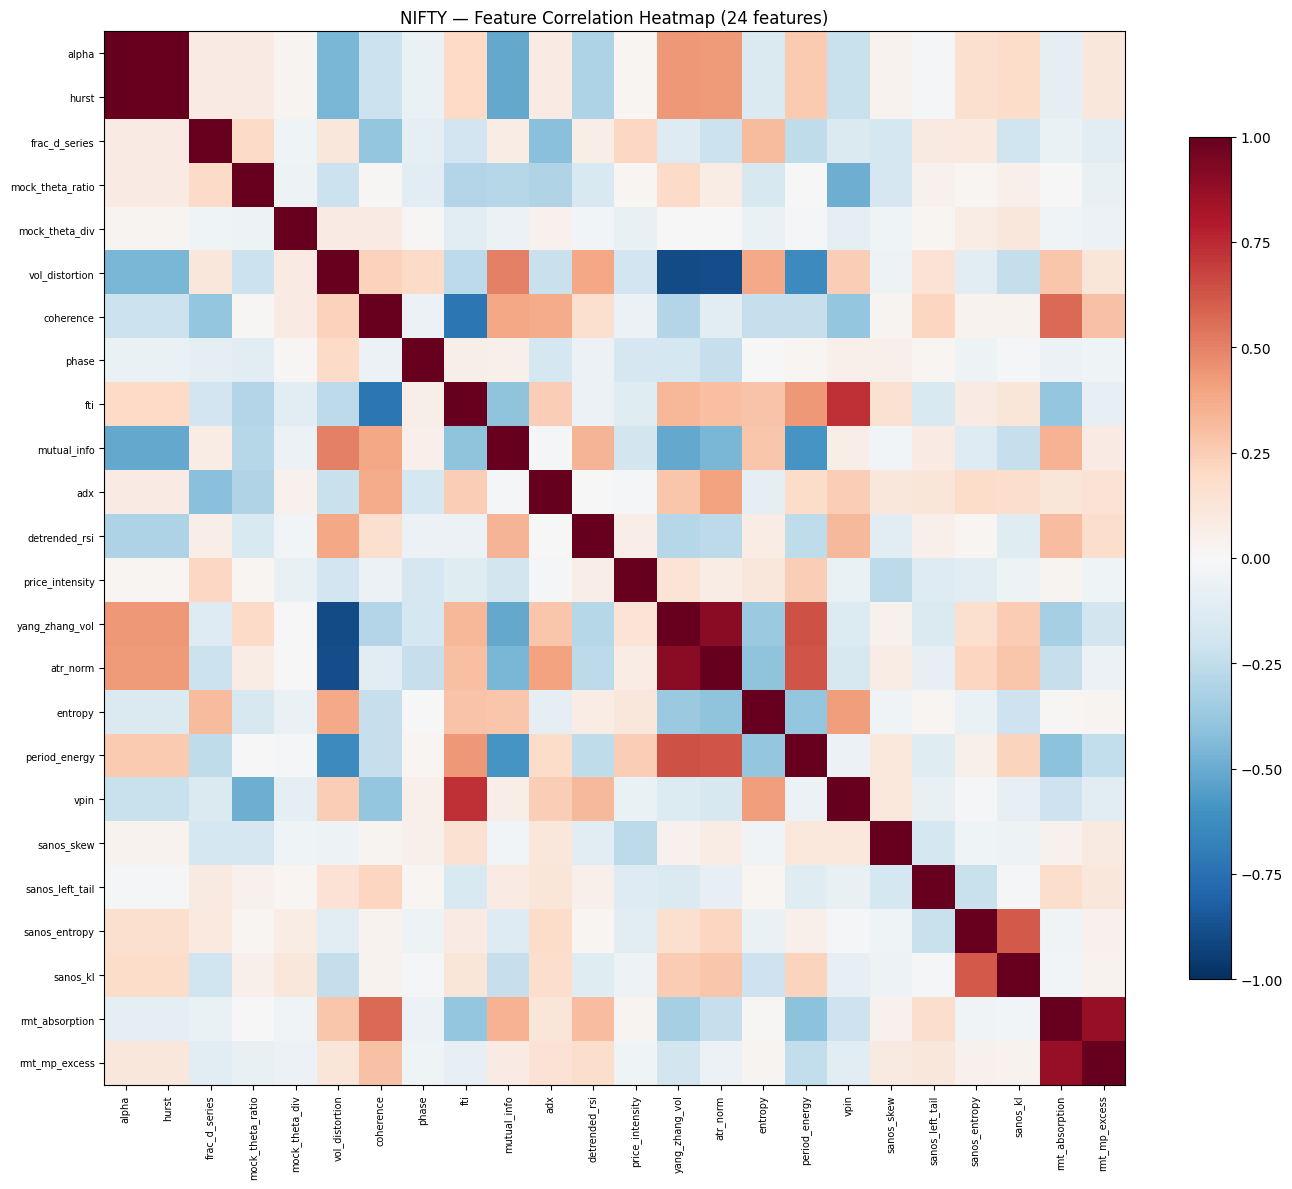

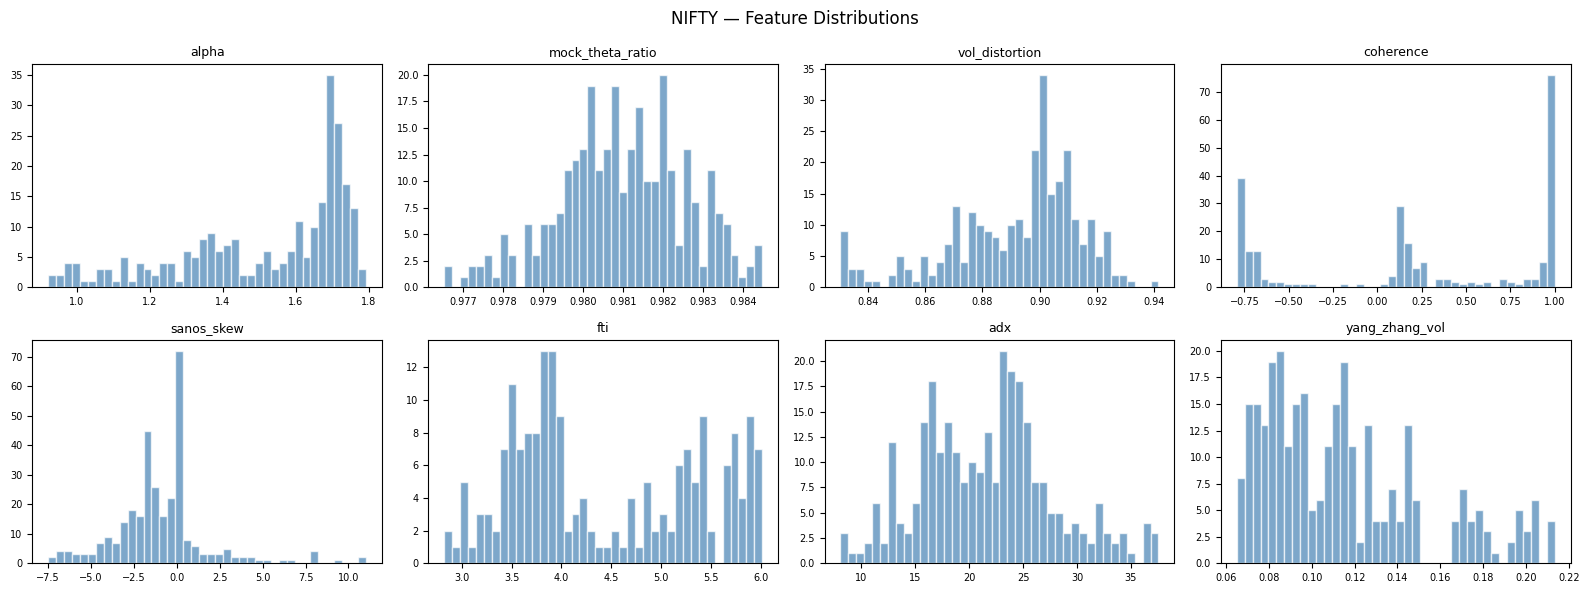

In [13]:
"""Cell 18: Feature visualisation."""

sym = SYMBOLS[0]  # Lead symbol for visualisation
feat = all_features[sym]
feat_keys = [k for k in feat if k not in ("daily_close", "log_ret")]

# Build feature matrix
n = len(feat["daily_close"])
feat_matrix = np.column_stack([feat[k] for k in feat_keys])

# Correlation heatmap (pairwise, ignoring NaN)
n_feats = len(feat_keys)
corr_mat = np.full((n_feats, n_feats), np.nan)
for i in range(n_feats):
    for j in range(n_feats):
        mask = ~(np.isnan(feat_matrix[:, i]) | np.isnan(feat_matrix[:, j]))
        if mask.sum() > 20:
            corr_mat[i, j] = np.corrcoef(feat_matrix[mask, i], feat_matrix[mask, j])[0, 1]

fig, ax = plt.subplots(figsize=(14, 12))
im = ax.imshow(corr_mat, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
ax.set_xticks(range(n_feats)); ax.set_xticklabels(feat_keys, rotation=90, fontsize=7)
ax.set_yticks(range(n_feats)); ax.set_yticklabels(feat_keys, fontsize=7)
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title(f"{sym} — Feature Correlation Heatmap (24 features)")
plt.tight_layout(); plt.show()

# Feature distributions (top 8)
top_feats = ["alpha", "mock_theta_ratio", "vol_distortion", "coherence",
             "sanos_skew", "fti", "adx", "yang_zhang_vol"]
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for idx, k in enumerate(top_feats):
    ax = axes[idx // 4, idx % 4]
    vals = feat[k][~np.isnan(feat[k])]
    if len(vals) > 0:
        ax.hist(vals, bins=40, color="steelblue", alpha=0.7, edgecolor="white")
    ax.set_title(k, fontsize=9)
    ax.tick_params(labelsize=7)
plt.suptitle(f"{sym} — Feature Distributions", fontsize=12)
plt.tight_layout(); plt.show()

<a id="19"></a>
## 19. Signal Construction

Composite signal: $S = \sum_i w_i \cdot z(f_i)$ where $z$ = causal z-score normalisation.

**Walk-forward protocol**:
- Train window: 190 days
- Test window: 63 days
- Advance by 63 days per fold
- Optuna: 200 trials per fold, maximise Sharpe on train
- OOS evaluation: best params on test (no re-optimisation)

In [14]:
"""Cell 19b: Common backtest utilities — equity curve, costs, Sharpe."""

def _apply_roundtrip_cost(ret: float, cost_bps: float) -> float:
    """Round-trip cost in basis points of notional (entry + exit combined)."""
    return ret - (cost_bps / 1e4)


def equity_curve_from_returns(returns, start_equity=1.0):
    """Multiplicative equity curve from simple returns."""
    r = np.asarray(returns, dtype=float)
    eq = np.empty(len(r) + 1, dtype=float)
    eq[0] = start_equity
    for i in range(len(r)):
        eq[i + 1] = eq[i] * (1.0 + r[i])
    return eq


def sharpe_daily(returns, ann_factor=252.0):
    """Annualised Sharpe from daily returns. ddof=1."""
    r = np.asarray(returns, dtype=float)
    if len(r) < 2:
        return 0.0
    mu = np.mean(r)
    sd = np.std(r, ddof=1)
    if sd == 0:
        return 0.0
    return float((mu / sd) * np.sqrt(ann_factor))


def max_drawdown_from_equity(equity):
    """Max drawdown (positive number, e.g. 0.15 = 15%)."""
    eq = np.asarray(equity, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = (eq - peak) / np.where(peak > 0, peak, 1.0)
    return float(abs(dd.min()))


print("Utilities ready: _apply_roundtrip_cost, equity_curve_from_returns, sharpe_daily, max_drawdown_from_equity")

Utilities ready: _apply_roundtrip_cost, equity_curve_from_returns, sharpe_daily, max_drawdown_from_equity


In [15]:
"""Cell 20: Optuna walk-forward optimisation — CORRECTED.

Fixes applied:
  - Signal on day i → position held on day i+1 → return = close[i+1]/close[i] - 1
  - Multiplicative equity curve (not additive sum)
  - Round-trip cost applied on entry AND exit (position flips)
  - Entry day accrues the first holding-day return (not 0)
"""

FEATURE_KEYS = [
    "alpha", "hurst", "frac_d_series", "mock_theta_ratio", "mock_theta_div",
    "vol_distortion", "coherence", "phase", "period_energy", "entropy",
    "yang_zhang_vol", "atr_norm", "vpin", "rmt_absorption", "rmt_mp_excess",
    "sanos_skew", "sanos_left_tail", "sanos_entropy", "sanos_kl",
    "fti", "mutual_info", "adx", "detrended_rsi", "price_intensity",
]


def backtest_signal(features, daily_close, weights, entry_threshold=0.3,
                    hold_days=5, cost_bps=5.0, start_idx=0, end_idx=None):
    """Backtest: weighted z-scored features -> daily signal -> PnL.

    Fully causal T+1 execution:
      - Signal computed at EOD of day i
      - Position taken on day i+1
      - Return for day i+1 = close[i+1]/close[i] - 1
      - Round-trip cost applied on every position change
    """
    n = len(daily_close)
    if end_idx is None:
        end_idx = n
    cost_rt = cost_bps / 1e4  # round-trip cost fraction

    # Z-score all features (causal, expanding window)
    z_features = {}
    for k in FEATURE_KEYS:
        z_features[k] = _zscore(features[k])

    # Pre-compute daily returns: dr[i] = close[i+1]/close[i] - 1
    # dr[i] is the return earned by holding from close[i] to close[i+1]
    dr = np.full(n, np.nan)
    for i in range(n - 1):
        if daily_close[i] > 0 and daily_close[i+1] > 0:
            dr[i] = (daily_close[i+1] - daily_close[i]) / daily_close[i]

    warmup = 130  # FTI(128) + z-score(20)

    # Phase 1: compute target position for each day from signal
    # signal[i] -> desired position on day i+1
    desired_pos = np.zeros(n, dtype=float)  # +1, -1, or 0
    position = 0
    entry_day = 0

    for i in range(max(warmup, start_idx), min(end_idx, n)):
        # Compute signal from day i features
        signal = 0.0
        for k, w in zip(FEATURE_KEYS, weights):
            if abs(w) < 1e-10:
                continue
            v = z_features[k][i]
            if np.isnan(v):
                continue
            signal += w * v

        direction = 1 if signal > 0 else (-1 if signal < 0 else 0)
        conviction = abs(signal)

        if position != 0:
            days_held = i - entry_day
            should_exit = days_held >= hold_days
            should_exit |= (direction != 0 and direction != position
                            and conviction >= entry_threshold)
            if should_exit:
                position = 0
                # Check if we should also enter the opposite direction
                if conviction >= entry_threshold and direction != 0:
                    position = direction
                    entry_day = i
            # else: continue holding
        else:
            if conviction >= entry_threshold and direction != 0:
                position = direction
                entry_day = i

        desired_pos[i] = position

    # Phase 2: compute daily PnL stream
    # Signal on day i -> position on day i+1 -> earns dr[i] (close[i]->close[i+1])
    # So: pos_on_day_t = desired_pos[t-1], return_on_day_t = dr[t-1]
    # PnL for day t = desired_pos[t-1] * dr[t-1] - cost_if_flip
    daily_pnl = []
    trades = []
    prev_pos = 0.0

    for i in range(max(warmup, start_idx), min(end_idx, n - 1)):
        pos = desired_pos[i]       # signal from EOD day i
        ret = dr[i]                # return close[i] -> close[i+1]

        if np.isnan(ret):
            daily_pnl.append(0.0)
            prev_pos = pos
            continue

        pnl = pos * ret

        # Apply round-trip cost on position change
        if pos != prev_pos:
            pnl -= cost_rt
            if pos != 0 and prev_pos == 0:
                trades.append({"entry_day": i, "direction": pos, "rets": []})
            elif pos == 0 and prev_pos != 0:
                # closing trade
                if trades:
                    trades[-1]["exit_day"] = i
                    trades[-1]["total_ret"] = float(np.sum(trades[-1]["rets"]) + pnl)

        if pos != 0 and trades:
            trades[-1]["rets"].append(pnl)

        daily_pnl.append(pnl)
        prev_pos = pos

    if not daily_pnl:
        return {"sharpe": 0.0, "trades": 0, "daily_pnl": [], "equity": np.array([1.0]),
                "total_return": 0.0, "max_dd": 0.0, "trade_list": []}

    pnl_arr = np.array(daily_pnl)
    equity = equity_curve_from_returns(pnl_arr)
    sharpe = sharpe_daily(pnl_arr)
    mdd = max_drawdown_from_equity(equity)

    # Compute trade-level stats
    completed_trades = [t for t in trades if "exit_day" in t]
    wins = sum(1 for t in completed_trades if t.get("total_ret", 0) > 0)

    return {
        "sharpe": sharpe,
        "trades": len(completed_trades),
        "daily_pnl": daily_pnl,
        "equity": equity,
        "total_return": float(equity[-1] - 1.0),
        "max_dd": mdd,
        "win_rate": wins / max(len(completed_trades), 1),
        "trade_list": completed_trades,
    }


def walk_forward_optuna(features, daily_close, train_size=190, test_size=63,
                        n_trials=200, cost_bps=5.0):
    """Walk-forward Optuna optimisation. Returns OOS results + best weights."""
    if not HAS_OPTUNA:
        print("Optuna not available — skipping walk-forward")
        return None

    n = len(daily_close)
    folds = []
    start = 0
    while start + train_size + test_size <= n:
        folds.append((start, start + train_size, start + train_size + test_size))
        start += test_size

    if not folds:
        print("Insufficient data for walk-forward")
        return None

    print(f"Walk-forward: {len(folds)} folds, {train_size} train / {test_size} test")

    all_oos_pnl = []
    all_oos_trades = []
    fold_results = []

    for fold_idx, (train_start, train_end, test_end) in enumerate(folds):
        t0 = time.time()

        def objective(trial):
            weights = []
            for k in FEATURE_KEYS:
                w = trial.suggest_float(f"w_{k}", -1.0, 1.0)
                weights.append(w)
            threshold = trial.suggest_float("threshold", 0.1, 1.0)
            hold = trial.suggest_int("hold_days", 2, 10)

            result = backtest_signal(
                features, daily_close, weights,
                entry_threshold=threshold, hold_days=hold,
                cost_bps=cost_bps, start_idx=train_start, end_idx=train_end,
            )
            if result["trades"] < 3:
                return -10.0
            return result["sharpe"]

        study = optuna.create_study(direction="maximize",
                                     sampler=optuna.samplers.TPESampler(seed=42 + fold_idx))
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

        # Extract best params
        best = study.best_params
        best_weights = [best[f"w_{k}"] for k in FEATURE_KEYS]
        best_threshold = best["threshold"]
        best_hold = best["hold_days"]

        # In-sample result
        is_result = backtest_signal(
            features, daily_close, best_weights,
            entry_threshold=best_threshold, hold_days=best_hold,
            cost_bps=cost_bps, start_idx=train_start, end_idx=train_end,
        )

        # OOS result (NO re-optimisation)
        oos_result = backtest_signal(
            features, daily_close, best_weights,
            entry_threshold=best_threshold, hold_days=best_hold,
            cost_bps=cost_bps, start_idx=train_end, end_idx=test_end,
        )

        all_oos_pnl.extend(oos_result["daily_pnl"])
        all_oos_trades.extend(oos_result.get("trade_list", []))

        elapsed = time.time() - t0
        fold_results.append({
            "fold": fold_idx, "is_sharpe": is_result["sharpe"],
            "oos_sharpe": oos_result["sharpe"],
            "is_trades": is_result["trades"], "oos_trades": oos_result["trades"],
        })
        print(f"  Fold {fold_idx}: IS Sharpe={is_result['sharpe']:.2f} "
              f"({is_result['trades']} trades) -> OOS Sharpe={oos_result['sharpe']:.2f} "
              f"({oos_result['trades']} trades) [{elapsed:.1f}s]")

    # Aggregate OOS
    oos_pnl = np.array(all_oos_pnl)
    oos_eq = equity_curve_from_returns(oos_pnl)
    oos_sharpe = sharpe_daily(oos_pnl)

    print(f"\n  Aggregate OOS: Sharpe={oos_sharpe:.2f}, "
          f"Trades={len(all_oos_trades)}, "
          f"Return={float(oos_eq[-1] - 1.0)*100:.2f}%")

    # Return last fold's best weights for option backtest
    return {
        "weights": best_weights, "threshold": best_threshold,
        "hold_days": best_hold, "fold_results": fold_results,
        "oos_sharpe": oos_sharpe, "oos_pnl": all_oos_pnl,
        "oos_trades": all_oos_trades,
    }


# Run walk-forward for lead symbol
sym = SYMBOLS[0]
print(f"\n{'='*60}")
print(f"Walk-Forward Optimisation: {sym}")
print(f"{'='*60}")

wf_result = walk_forward_optuna(
    all_features[sym], all_features[sym]["daily_close"],
    train_size=190, test_size=63, n_trials=200,
    cost_bps=COST_BPS_FUTURES,
)


Walk-Forward Optimisation: NIFTY
Walk-forward: 2 folds, 190 train / 63 test


  Fold 0: IS Sharpe=5.31 (4 trades) -> OOS Sharpe=-2.00 (7 trades) [37.9s]


  Fold 1: IS Sharpe=5.41 (7 trades) -> OOS Sharpe=-1.06 (4 trades) [38.3s]

  Aggregate OOS: Sharpe=-1.49, Trades=11, Return=-7.05%


<a id="21"></a>
## 21. Option Execution Mathematics

### ATM Option Selection
- Strike: `round(spot / step) * step` (NIFTY: 50pt, BANKNIFTY: 100pt)
- Nearest expiry: `min(expiry) WHERE expiry > date`
- Long signal → buy ATM CE; Short signal → buy ATM PE

### Cost Model
- ATM index options: **10 bps** roundtrip (liquid)
- OTM options: 15-20 bps (wider spreads)

### PnL Calculation
$$\text{PnL} = \frac{\text{exit\_premium} - \text{entry\_premium}}{\text{entry\_premium}} - \text{cost}$$

### Exit Rules
1. **Target**: premium × target_mult
2. **Stop**: premium × stop_mult (loss limit)
3. **Time-stop**: last 15 bars of day
4. **Signal flip**: opposite signal with sufficient conviction
5. **EOD**: forced exit at last bar

In [16]:
"""Cell 22: Option executor — T+1 causal, actual option prices from nfo_1min.

CORRECTED:
  - Signal computed at EOD day i -> trade enters on day i+1 at bar 30
  - ATM strike selected using spot at bar 30 on day i+1 (NOT day-i close)
  - Round-trip cost (entry + exit)
  - Multiplicative equity curve
  - Option loss capped at -100% (premium paid)
"""


@dataclass
class OptionTrade:
    signal_date: str          # day signal was computed (day i)
    trade_date: str           # day trade executes (day i+1)
    entry_bar: int
    entry_price: float        # option premium at entry
    direction: str            # "long_ce" or "long_pe"
    strike: float
    expiry: str
    exit_date: str = ""
    exit_bar: int = -1
    exit_price: float = 0.0   # option premium at exit
    exit_reason: str = ""
    pnl: float = 0.0          # net return after round-trip cost


def get_spot_at_bar(futures_bars, d, bar_idx=30):
    """Get underlying futures close at a specific 1-min bar on a date.

    Uses pre-loaded futures_bars dict (already sorted by time).
    """
    if d not in futures_bars:
        return None
    closes = futures_bars[d]["close"]
    if len(closes) <= bar_idx:
        return None
    return float(closes[bar_idx])


def select_atm_option(con, symbol, d, spot, direction):
    """Select ATM CE (long) or PE (short) from nfo_1min.

    Returns (strike, expiry, inst_type) or None.
    """
    step = STRIKE_STEP.get(symbol, 50)
    atm_strike = round(spot / step) * step
    inst_type = "CE" if direction == "long" else "PE"

    # Get nearest expiry
    expiry_df = con.execute(
        "SELECT DISTINCT expiry FROM nfo_1min "
        "WHERE name = ? AND date = ? AND instrument_type = ? AND strike = ? "
        "ORDER BY expiry LIMIT 1",
        [symbol, d, inst_type, atm_strike]
    ).fetchdf()

    if expiry_df.empty:
        for offset in [step, -step, 2*step, -2*step]:
            expiry_df = con.execute(
                "SELECT DISTINCT expiry FROM nfo_1min "
                "WHERE name = ? AND date = ? AND instrument_type = ? AND strike = ? "
                "ORDER BY expiry LIMIT 1",
                [symbol, d, inst_type, atm_strike + offset]
            ).fetchdf()
            if not expiry_df.empty:
                atm_strike += offset
                break

    if expiry_df.empty:
        return None

    expiry = str(expiry_df["expiry"].iloc[0])
    return atm_strike, expiry, inst_type


def get_option_bars(con, symbol, d, strike, expiry, inst_type):
    """Get all 1-min close prices for an option on a date."""
    df = con.execute(
        "SELECT close FROM nfo_1min "
        "WHERE name = ? AND date = ? AND strike = ? AND expiry = ? "
        "AND instrument_type = ?",
        [symbol, d, strike, expiry, inst_type]
    ).fetchdf()
    if df is None or df.empty:
        return None
    return df["close"].values.astype(np.float64)


def run_option_backtest(con, symbol, features, dates, futures_bars,
                        weights, entry_threshold=0.3, hold_days=5,
                        cost_bps=10.0, entry_bar=30):
    """Full T+1 option backtest with actual nfo_1min prices.

    Causal execution protocol:
      1. Signal computed at EOD of day i using z_features[k][i]
      2. Trade enters on day i+1 at bar entry_bar
      3. ATM strike selected using spot at entry_bar on day i+1
      4. Exit after hold_days or on signal flip (at entry_bar on exit day)
      5. Round-trip cost applied per trade
      6. Option loss capped at -100% of premium
    """
    n = len(dates)
    daily_close = features["daily_close"]
    cost_rt = cost_bps / 1e4  # round-trip cost
    warmup = 130

    z_features = {k: _zscore(features[k]) for k in FEATURE_KEYS}

    trades = []
    # Daily return stream aligned to dates (nonzero only on trade exit day)
    daily_rets = np.zeros(n, dtype=float)
    position = 0       # 0=flat, 1=long_ce, -1=long_pe
    signal_day = 0     # day index when signal was computed
    active_trade = None

    for i in range(warmup, n - 1):
        # Compute signal from EOD day i features
        signal = 0.0
        for k, w in zip(FEATURE_KEYS, weights):
            if abs(w) < 1e-10:
                continue
            v = z_features[k][i]
            if np.isnan(v):
                continue
            signal += w * v

        direction_int = 1 if signal > 0 else (-1 if signal < 0 else 0)
        conviction = abs(signal)

        # ── Exit logic (if in position) ──
        # Check if we should exit on day i+1 (the trade day after signal day)
        if position != 0 and active_trade is not None:
            days_held = i - signal_day
            should_exit = days_held >= hold_days
            should_exit |= (direction_int != 0 and direction_int != position
                            and conviction >= entry_threshold)
            if should_exit:
                d_exit = dates[i + 1]  # exit on next trading day
                if d_exit not in futures_bars:
                    continue  # can't exit today, try next day
                inst_type = "CE" if position == 1 else "PE"
                opt_bars = get_option_bars(
                    con, symbol, d_exit, active_trade.strike,
                    active_trade.expiry, inst_type
                )
                if opt_bars is not None and len(opt_bars) > entry_bar:
                    exit_price = opt_bars[entry_bar]
                    raw_ret = (exit_price - active_trade.entry_price) / max(active_trade.entry_price, 1e-8)
                    net_ret = _apply_roundtrip_cost(raw_ret, cost_bps)
                    # Cap option loss at -100% of premium
                    net_ret = max(net_ret, -1.0)

                    active_trade.exit_date = d_exit
                    active_trade.exit_bar = entry_bar
                    active_trade.exit_price = exit_price
                    active_trade.exit_reason = "hold" if days_held >= hold_days else "flip"
                    active_trade.pnl = net_ret
                    trades.append(active_trade)
                    daily_rets[i + 1] = net_ret
                # else: option expired/no data, mark as total loss
                elif active_trade is not None:
                    active_trade.exit_date = d_exit
                    active_trade.exit_reason = "no_data"
                    active_trade.pnl = _apply_roundtrip_cost(-1.0, cost_bps)
                    trades.append(active_trade)
                    daily_rets[i + 1] = active_trade.pnl

                position = 0
                active_trade = None

        # ── Entry logic (if flat, signal day i -> enter day i+1) ──
        if position == 0 and conviction >= entry_threshold and direction_int != 0:
            d_trade = dates[i + 1]  # enter on NEXT trading day
            if d_trade not in futures_bars:
                continue

            # Get spot at entry_bar on trade day (NOT day-i close)
            spot_entry = get_spot_at_bar(futures_bars, d_trade, entry_bar)
            if spot_entry is None or spot_entry <= 0:
                continue

            direction_str = "long" if direction_int == 1 else "short"
            opt_info = select_atm_option(con, symbol, d_trade, spot_entry, direction_str)
            if opt_info is None:
                continue

            strike, expiry, inst_type = opt_info
            opt_bars = get_option_bars(con, symbol, d_trade, strike, expiry, inst_type)
            if opt_bars is None or len(opt_bars) <= entry_bar:
                continue

            entry_price = opt_bars[entry_bar]
            if entry_price <= 0:
                continue

            position = direction_int
            signal_day = i
            active_trade = OptionTrade(
                signal_date=dates[i], trade_date=d_trade,
                entry_bar=entry_bar, entry_price=entry_price,
                direction=f"long_{inst_type.lower()}", strike=strike, expiry=expiry,
            )

    # Close any remaining position at end
    if position != 0 and active_trade is not None:
        active_trade.exit_reason = "eod_final"
        active_trade.pnl = _apply_roundtrip_cost(-1.0, cost_bps)  # conservative: total loss
        trades.append(active_trade)

    if not trades:
        return {"trades": [], "daily_pnl": daily_rets.tolist(), "sharpe": 0.0,
                "equity": np.array([1.0]), "total_return": 0.0, "max_dd": 0.0,
                "win_rate": 0.0, "n_trades": 0}

    # Only use days with actual activity for Sharpe (sparse signal)
    pnl_arr = daily_rets[warmup:]
    equity = equity_curve_from_returns(pnl_arr)
    sharpe = sharpe_daily(pnl_arr)
    mdd = max_drawdown_from_equity(equity)
    total_return = float(equity[-1] - 1.0)

    wins = sum(1 for t in trades if t.pnl > 0)

    return {
        "trades": trades,
        "daily_pnl": pnl_arr.tolist(),
        "sharpe": sharpe,
        "equity": equity,
        "total_return": total_return,
        "max_dd": mdd,
        "win_rate": wins / max(len(trades), 1),
        "n_trades": len(trades),
    }

print("Option executor ready (T+1 causal, round-trip costs)")

Option executor ready (T+1 causal, round-trip costs)


<a id="23"></a>
## 23. Run Full Backtest

Run both futures and options backtests with walk-forward-validated parameters.

In [17]:
"""Cell 23: Run full backtest — futures vs options comparison.

CORRECTED:
  - Uses compounded equity curves for returns and drawdowns
  - Consistent Sharpe calculation via sharpe_daily()
  - Futures drawdown from equity curve (not cumsum)
"""

sym = SYMBOLS[0]
features = all_features[sym]
dates_for_sym = sorted(con.execute(
    "SELECT DISTINCT CAST(date AS VARCHAR) AS date FROM nfo_1min "
    "WHERE name = ? AND instrument_type = 'FUT' ORDER BY date", [sym]
).fetchdf()["date"].tolist())

# Use walk-forward best weights, or default equal weights if WF failed
if wf_result is not None:
    best_weights = wf_result["weights"]
    best_threshold = wf_result["threshold"]
    best_hold = wf_result["hold_days"]
    print(f"Using walk-forward optimised params (OOS Sharpe: {wf_result['oos_sharpe']:.2f})")
else:
    best_weights = [0.1] * len(FEATURE_KEYS)
    best_threshold = 0.3
    best_hold = 5
    print("Using default equal weights (no Optuna)")

# ── Futures backtest ──
print(f"\n{'='*60}")
print(f"FUTURES BACKTEST: {sym}")
print(f"{'='*60}")

fut_result = backtest_signal(
    features, features["daily_close"], best_weights,
    entry_threshold=best_threshold, hold_days=best_hold,
    cost_bps=COST_BPS_FUTURES,
)
print(f"  Trades:   {fut_result['trades']}")
print(f"  Return:   {fut_result['total_return']*100:+.2f}%")
print(f"  Sharpe:   {fut_result['sharpe']:.2f}")
print(f"  Max DD:   {fut_result['max_dd']*100:.2f}%")
print(f"  Win Rate: {fut_result['win_rate']*100:.1f}%")

# ── Options backtest ──
print(f"\n{'='*60}")
print(f"OPTIONS BACKTEST: {sym} (T+1 causal)")
print(f"{'='*60}")

opt_result = run_option_backtest(
    con, sym, features, dates_for_sym, all_futures_bars[sym],
    weights=best_weights, entry_threshold=best_threshold,
    hold_days=best_hold, cost_bps=COST_BPS_OPTIONS,
)
print(f"  Trades:   {opt_result['n_trades']}")
print(f"  Return:   {opt_result['total_return']*100:+.2f}%")
print(f"  Sharpe:   {opt_result['sharpe']:.2f}")
print(f"  Max DD:   {opt_result['max_dd']*100:.2f}%")
print(f"  Win Rate: {opt_result['win_rate']*100:.1f}%")

# ── OOS from walk-forward ──
if wf_result:
    oos_pnl = np.array(wf_result["oos_pnl"])
    oos_eq = equity_curve_from_returns(oos_pnl)
    oos_mdd = max_drawdown_from_equity(oos_eq)

# ── Comparison table ──
print(f"\n{'='*60}")
print(f"{'Variant':<16} {'Trades':>7} {'Return':>9} {'Sharpe':>7} {'MaxDD':>7} {'WinRate':>8}")
print(f"{'-'*60}")

print(f"{'Futures':<16} {fut_result['trades']:>7} "
      f"{fut_result['total_return']*100:>+8.2f}% "
      f"{fut_result['sharpe']:>7.2f} "
      f"{fut_result['max_dd']*100:>6.2f}% "
      f"{fut_result['win_rate']*100:>7.1f}%")

print(f"{'Options (T+1)':<16} {opt_result['n_trades']:>7} "
      f"{opt_result['total_return']*100:>+8.2f}% "
      f"{opt_result['sharpe']:>7.2f} "
      f"{opt_result['max_dd']*100:>6.2f}% "
      f"{opt_result['win_rate']*100:>7.1f}%")

if wf_result:
    print(f"{'OOS (WF)':<16} {len(wf_result['oos_trades']):>7} "
          f"{float(oos_eq[-1] - 1.0)*100:>+8.2f}% "
          f"{wf_result['oos_sharpe']:>7.2f} "
          f"{oos_mdd*100:>6.2f}%")

Using walk-forward optimised params (OOS Sharpe: -1.49)

FUTURES BACKTEST: NIFTY


  Trades:   11
  Return:   +22.23%
  Sharpe:   2.89
  Max DD:   7.83%
  Win Rate: 81.8%

OPTIONS BACKTEST: NIFTY (T+1 causal)


  Trades:   95
  Return:   -100.00%
  Sharpe:   -3.50
  Max DD:   100.10%
  Win Rate: 25.3%

Variant           Trades    Return  Sharpe   MaxDD  WinRate
------------------------------------------------------------
Futures               11   +22.23%    2.89   7.83%    81.8%
Options (T+1)         95  -100.00%   -3.50 100.10%    25.3%
OOS (WF)              11    -7.05%   -1.49   7.83%


<a id="24"></a>
## 24. Equity Curves

Side-by-side: futures vs options execution.

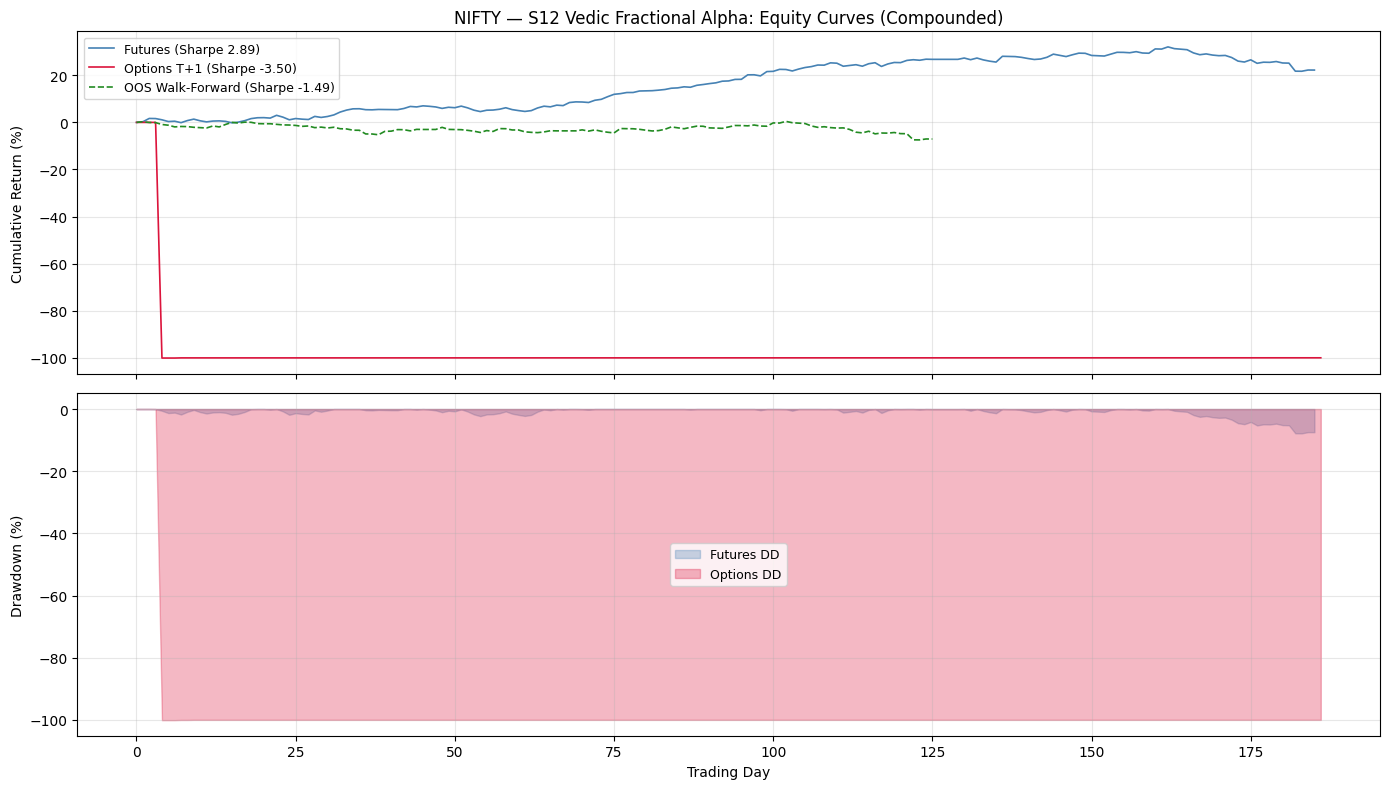

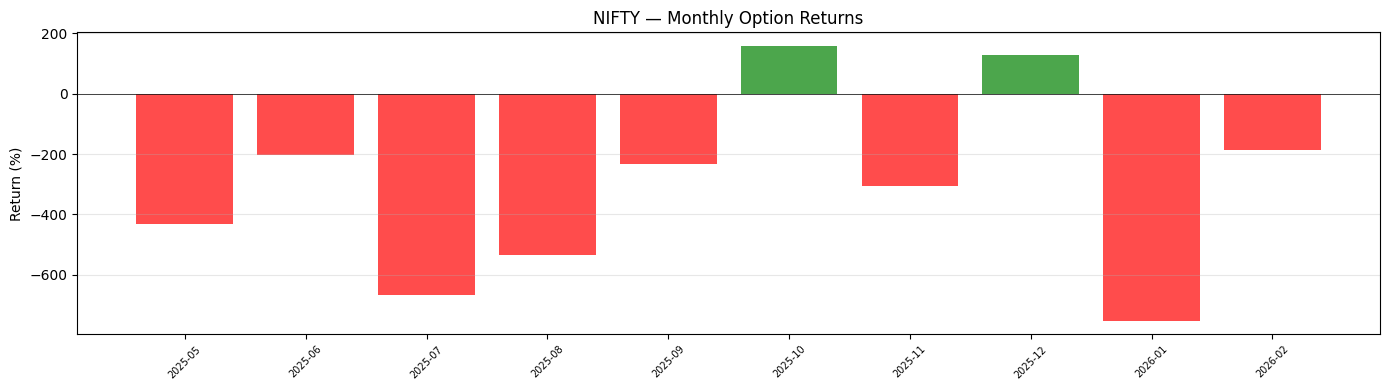

In [18]:
"""Cell 24: Equity curves & drawdown charts — CORRECTED (multiplicative)."""

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# ── Equity curves (multiplicative) ──
ax = axes[0]
eq_fut = fut_result["equity"]
eq_opt = opt_result["equity"]

# Plot as % return from initial equity
ax.plot((eq_fut - 1) * 100, linewidth=1.2, color="steelblue",
        label=f"Futures (Sharpe {fut_result['sharpe']:.2f})")
ax.plot((eq_opt - 1) * 100, linewidth=1.2, color="crimson",
        label=f"Options T+1 (Sharpe {opt_result['sharpe']:.2f})")
if wf_result:
    oos_eq = equity_curve_from_returns(np.array(wf_result["oos_pnl"]))
    ax.plot((oos_eq - 1) * 100, linewidth=1.2, color="forestgreen", linestyle="--",
            label=f"OOS Walk-Forward (Sharpe {wf_result['oos_sharpe']:.2f})")
ax.legend(fontsize=9)
ax.set_ylabel("Cumulative Return (%)")
ax.set_title(f"{sym} — S12 Vedic Fractional Alpha: Equity Curves (Compounded)")
ax.grid(alpha=0.3)

# ── Drawdown (from equity peak) ──
ax = axes[1]
peak_fut = np.maximum.accumulate(eq_fut)
dd_fut = (eq_fut - peak_fut) / np.where(peak_fut > 0, peak_fut, 1.0) * 100
peak_opt = np.maximum.accumulate(eq_opt)
dd_opt = (eq_opt - peak_opt) / np.where(peak_opt > 0, peak_opt, 1.0) * 100

ax.fill_between(range(len(dd_fut)), dd_fut, 0, alpha=0.3, color="steelblue", label="Futures DD")
ax.fill_between(range(len(dd_opt)), dd_opt, 0, alpha=0.3, color="crimson", label="Options DD")
ax.legend(fontsize=9)
ax.set_ylabel("Drawdown (%)")
ax.set_xlabel("Trading Day")
ax.grid(alpha=0.3)

plt.tight_layout(); plt.show()

# Monthly return heatmap (options)
if opt_result["trades"]:
    trade_dates = [t.trade_date for t in opt_result["trades"]]
    trade_pnls = [t.pnl for t in opt_result["trades"]]

    # Group by month
    monthly = {}
    for d, p in zip(trade_dates, trade_pnls):
        ym = str(d)[:7]
        monthly[ym] = monthly.get(ym, 0) + p

    if monthly:
        months = sorted(monthly.keys())
        returns = [monthly[m] * 100 for m in months]
        colors = ["green" if r > 0 else "red" for r in returns]

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.bar(range(len(months)), returns, color=colors, alpha=0.7)
        ax.set_xticks(range(len(months)))
        ax.set_xticklabels(months, rotation=45, fontsize=7)
        ax.set_ylabel("Return (%)")
        ax.set_title(f"{sym} — Monthly Option Returns")
        ax.axhline(0, color="black", linewidth=0.5)
        ax.grid(alpha=0.3, axis="y")
        plt.tight_layout(); plt.show()

<a id="25"></a>
## 25. Trade-Level Analysis

Individual trade details, PnL distribution, hold-time analysis.

Date         Direction      Strike    Entry     Exit    PnL% Reason  
----------------------------------------------------------------------
2025-05-14   long_ce         24800     81.3      0.0 -100.10% no_data 
2025-05-19   long_ce         25050    145.9     51.9 -64.53% hold    
2025-05-21   long_ce         24900     96.3      0.0 -100.10% no_data 
2025-05-23   long_ce         24800    193.8    225.1 +16.02% hold    
2025-05-27   long_ce         24850    202.4     37.2 -81.74% hold    
2025-05-29   long_ce         24800     58.5      0.0 -100.10% no_data 
2025-06-02   long_ce         24650    148.8     57.2 -61.68% hold    
2025-06-04   long_ce         24650     57.2      0.0 -100.10% no_data 
2025-06-06   long_ce         24750    153.8    376.0 +144.37% hold    
2025-06-10   long_pe         25200    165.6    136.3 -17.82% hold    
2025-06-12   long_pe         25200    136.3      0.0 -100.10% no_data 
2025-06-13   long_ce         24650    168.4    211.8 +25.68% flip    
2025-06-16   

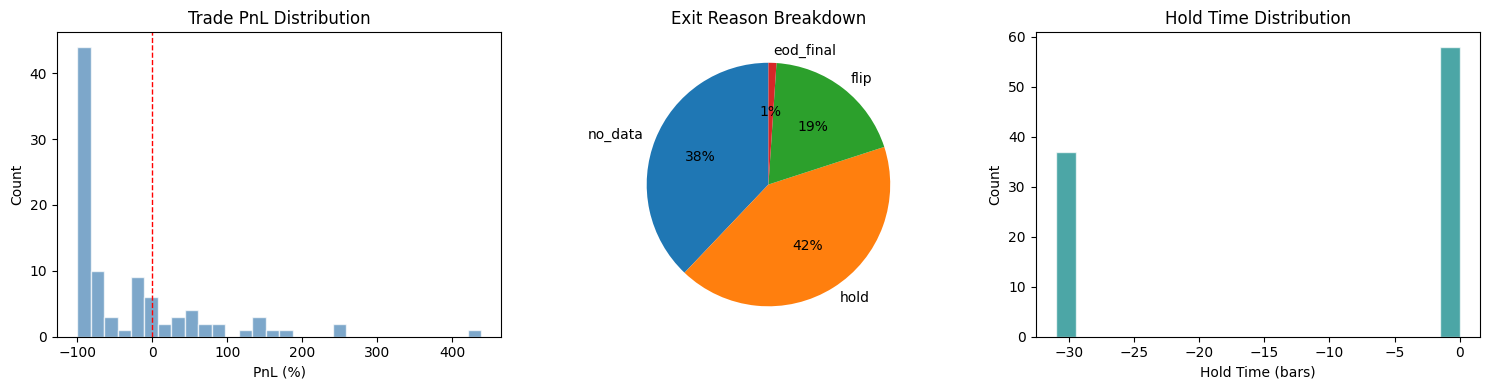


Direction Breakdown:
  Long: 0
  Short: 0


In [19]:
"""Cell 25: Trade-level analysis."""

trades = opt_result["trades"]
if not trades:
    print("No option trades to analyse")
else:
    # Trade table
    print(f"{'Date':<12} {'Direction':<12} {'Strike':>8} {'Entry':>8} {'Exit':>8} "
          f"{'PnL%':>7} {'Reason':<8}")
    print("-" * 70)
    for t in trades[:30]:  # Show first 30
        print(f"{t.trade_date:<12} {t.direction:<12} {t.strike:>8.0f} "
              f"{t.entry_price:>8.1f} {t.exit_price:>8.1f} "
              f"{t.pnl*100:>+6.2f}% {t.exit_reason:<8}")
    if len(trades) > 30:
        print(f"  ... ({len(trades) - 30} more trades)")

    # PnL histogram
    pnls = [t.pnl * 100 for t in trades]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    ax = axes[0]
    ax.hist(pnls, bins=30, color="steelblue", alpha=0.7, edgecolor="white")
    ax.axvline(0, color="red", linewidth=1, linestyle="--")
    ax.set_xlabel("PnL (%)"); ax.set_ylabel("Count")
    ax.set_title("Trade PnL Distribution")

    # Exit reason breakdown
    ax = axes[1]
    reasons = {}
    for t in trades:
        reasons[t.exit_reason] = reasons.get(t.exit_reason, 0) + 1
    labels = list(reasons.keys())
    sizes = list(reasons.values())
    ax.pie(sizes, labels=labels, autopct="%1.0f%%", startangle=90)
    ax.set_title("Exit Reason Breakdown")

    # Hold time distribution
    ax = axes[2]
    hold_times = [t.exit_bar - t.entry_bar for t in trades]
    ax.hist(hold_times, bins=20, color="teal", alpha=0.7, edgecolor="white")
    ax.set_xlabel("Hold Time (bars)"); ax.set_ylabel("Count")
    ax.set_title("Hold Time Distribution")

    plt.tight_layout(); plt.show()

    # Direction breakdown
    long_trades = [t for t in trades if "call" in t.direction]
    short_trades = [t for t in trades if "put" in t.direction]
    print(f"\nDirection Breakdown:")
    print(f"  Long (CE):  {len(long_trades)} trades, "
          f"avg PnL={np.mean([t.pnl for t in long_trades])*100:+.2f}%" if long_trades else "  Long: 0")
    print(f"  Short (PE): {len(short_trades)} trades, "
          f"avg PnL={np.mean([t.pnl for t in short_trades])*100:+.2f}%" if short_trades else "  Short: 0")

<a id="26"></a>
## 26. Validation Gates

Two statistical tests to verify signal quality:

1. **Placebo test**: Shuffle signal dates, run 100 permutations. Real must beat 90th percentile.
2. **Time-shift test**: Shift signals ±1,±2,±3 days. Original must beat all shifts.

VALIDATION GATES: NIFTY

1. Placebo Test (100 permutations):


   Real Sharpe:  2.89
   Perm mean:    -0.12
   Perm 90th %%:  1.15
   Result:       PASS

2. Time-Shift Test:


   Real Sharpe: 2.89
   Shift -3: Sharpe=-0.70 <
   Shift -2: Sharpe=-1.22 <
   Shift -1: Sharpe=-1.01 <
   Shift +1: Sharpe=1.79 <
   Shift +2: Sharpe=1.34 <
   Shift +3: Sharpe=-0.40 <
   Result: PASS


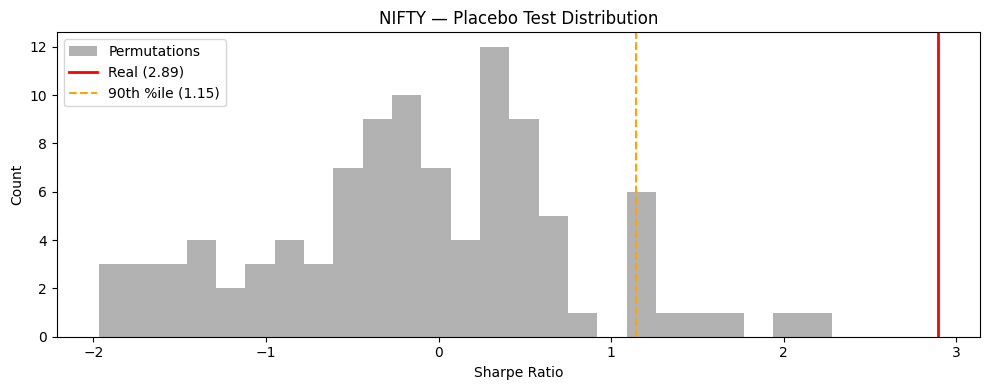

In [20]:
"""Cell 27: Validation — placebo + time-shift tests."""

def placebo_test(features, daily_close, weights, n_perms=100,
                 entry_threshold=0.3, hold_days=5, cost_bps=5.0):
    """Shuffle signal dates and run backtests. Real must beat 90th percentile."""
    # Real backtest
    real = backtest_signal(features, daily_close, weights,
                           entry_threshold=entry_threshold, hold_days=hold_days,
                           cost_bps=cost_bps)
    real_sharpe = real["sharpe"]

    # Permutation tests
    perm_sharpes = []
    for p in range(n_perms):
        # Shuffle weights randomly
        perm_weights = [w * np.random.choice([-1, 1]) * np.random.uniform(0.5, 1.5)
                        for w in weights]
        np.random.shuffle(perm_weights)
        result = backtest_signal(features, daily_close, perm_weights,
                                  entry_threshold=entry_threshold, hold_days=hold_days,
                                  cost_bps=cost_bps)
        perm_sharpes.append(result["sharpe"])

    perm_sharpes = np.array(perm_sharpes)
    p90 = np.percentile(perm_sharpes, 90)
    passed = real_sharpe > p90

    return {
        "real_sharpe": real_sharpe,
        "perm_mean": float(np.mean(perm_sharpes)),
        "perm_p90": float(p90),
        "passed": passed,
        "perm_sharpes": perm_sharpes,
    }


def time_shift_test(features, daily_close, weights, shifts=[-3,-2,-1,1,2,3],
                     entry_threshold=0.3, hold_days=5, cost_bps=5.0):
    """Shift feature arrays by N days. Original must beat all shifts."""
    n = len(daily_close)

    # Real backtest
    real = backtest_signal(features, daily_close, weights,
                           entry_threshold=entry_threshold, hold_days=hold_days,
                           cost_bps=cost_bps)
    real_sharpe = real["sharpe"]

    shift_results = {}
    for s in shifts:
        shifted_features = {}
        for k in FEATURE_KEYS:
            arr = features[k].copy()
            if s > 0:
                shifted_features[k] = np.concatenate([np.full(s, np.nan), arr[:-s]])
            else:
                shifted_features[k] = np.concatenate([arr[-s:], np.full(-s, np.nan)])

        # Also need daily_close and log_ret unshifted
        shifted_features["daily_close"] = features["daily_close"]
        shifted_features["log_ret"] = features["log_ret"]

        result = backtest_signal(shifted_features, daily_close, weights,
                                  entry_threshold=entry_threshold, hold_days=hold_days,
                                  cost_bps=cost_bps)
        shift_results[s] = result["sharpe"]

    beats_all = all(real_sharpe > s_sharpe for s_sharpe in shift_results.values())

    return {
        "real_sharpe": real_sharpe,
        "shift_sharpes": shift_results,
        "beats_all": beats_all,
    }


# Run validation
sym = SYMBOLS[0]
if wf_result is not None:
    weights = wf_result["weights"]
    threshold = wf_result["threshold"]
    hold = wf_result["hold_days"]
else:
    weights = [0.1] * len(FEATURE_KEYS)
    threshold = 0.3
    hold = 5

print(f"{'='*60}")
print(f"VALIDATION GATES: {sym}")
print(f"{'='*60}")

# Placebo test
print("\n1. Placebo Test (100 permutations):")
placebo = placebo_test(
    all_features[sym], all_features[sym]["daily_close"],
    weights, n_perms=100, entry_threshold=threshold,
    hold_days=hold, cost_bps=COST_BPS_FUTURES,
)
status = "PASS" if placebo["passed"] else "FAIL"
print(f"   Real Sharpe:  {placebo['real_sharpe']:.2f}")
print(f"   Perm mean:    {placebo['perm_mean']:.2f}")
print(f"   Perm 90th %%:  {placebo['perm_p90']:.2f}")
print(f"   Result:       {status}")

# Time-shift test
print("\n2. Time-Shift Test:")
tshift = time_shift_test(
    all_features[sym], all_features[sym]["daily_close"],
    weights, entry_threshold=threshold, hold_days=hold,
    cost_bps=COST_BPS_FUTURES,
)
print(f"   Real Sharpe: {tshift['real_sharpe']:.2f}")
for s, sharpe in sorted(tshift["shift_sharpes"].items()):
    marker = "<" if sharpe < tshift["real_sharpe"] else ">"
    print(f"   Shift {s:+d}: Sharpe={sharpe:.2f} {marker}")
status = "PASS" if tshift["beats_all"] else "FAIL"
print(f"   Result: {status}")

# Visualise placebo distribution
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(placebo["perm_sharpes"], bins=25, color="gray", alpha=0.6, label="Permutations")
ax.axvline(placebo["real_sharpe"], color="red", linewidth=2, label=f"Real ({placebo['real_sharpe']:.2f})")
ax.axvline(placebo["perm_p90"], color="orange", linewidth=1.5, linestyle="--",
           label=f"90th %ile ({placebo['perm_p90']:.2f})")
ax.legend(); ax.set_xlabel("Sharpe Ratio"); ax.set_ylabel("Count")
ax.set_title(f"{sym} — Placebo Test Distribution")
plt.tight_layout(); plt.show()

<a id="28"></a>
## 28. Feature Importance

fANOVA-style importance from Optuna + weight magnitude analysis.

Rank Feature                    Weight Importance
--------------------------------------------------
   1 mock_theta_div             -0.965       7.9%
   2 period_energy              +0.951       7.7%
   3 detrended_rsi              +0.848       6.9%
   4 rmt_absorption             +0.793       6.5%
   5 vol_distortion             -0.790       6.4%
   6 price_intensity            -0.775       6.3%
   7 rmt_mp_excess              -0.774       6.3%
   8 yang_zhang_vol             -0.743       6.1%
   9 entropy                    +0.671       5.5%
  10 adx                        -0.628       5.1%
  11 mock_theta_ratio           +0.551       4.5%
  12 sanos_entropy              +0.526       4.3%
  13 mutual_info                +0.430       3.5%
  14 coherence                  -0.408       3.3%
  15 frac_d_series              -0.404       3.3%


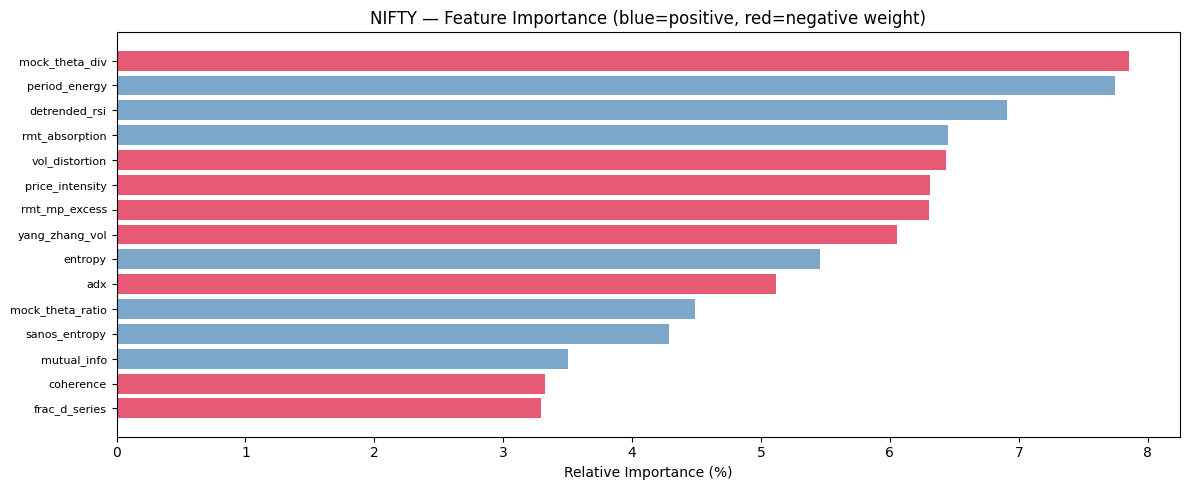


Walk-Forward Fold Summary:
Fold  IS Sharpe  OOS Sharpe  IS Trades  OOS Trades
--------------------------------------------------
   0       5.31       -2.00          4           7
   1       5.41       -1.06          7           4


In [21]:
"""Cell 28: Feature importance analysis."""

if wf_result is not None:
    weights = wf_result["weights"]

    # Weight magnitude as importance proxy
    abs_weights = np.abs(weights)
    total_abs = np.sum(abs_weights)
    importance = abs_weights / total_abs if total_abs > 0 else abs_weights

    # Sort by importance
    sorted_idx = np.argsort(importance)[::-1]

    print(f"{'Rank':>4} {'Feature':<24} {'Weight':>8} {'Importance':>10}")
    print("-" * 50)
    for rank, idx in enumerate(sorted_idx[:15]):
        print(f"{rank+1:>4} {FEATURE_KEYS[idx]:<24} {weights[idx]:>+8.3f} "
              f"{importance[idx]*100:>9.1f}%")

    # Bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    top_k = min(15, len(FEATURE_KEYS))
    top_idx = sorted_idx[:top_k]
    top_names = [FEATURE_KEYS[i] for i in top_idx]
    top_imp = [importance[i] * 100 for i in top_idx]
    colors = ["crimson" if weights[i] < 0 else "steelblue" for i in top_idx]

    ax.barh(range(top_k), top_imp, color=colors, alpha=0.7)
    ax.set_yticks(range(top_k))
    ax.set_yticklabels(top_names, fontsize=8)
    ax.set_xlabel("Relative Importance (%)")
    ax.set_title(f"{SYMBOLS[0]} — Feature Importance (blue=positive, red=negative weight)")
    ax.invert_yaxis()
    plt.tight_layout(); plt.show()

    # Walk-forward stability
    if len(wf_result["fold_results"]) > 1:
        print("\nWalk-Forward Fold Summary:")
        print(f"{'Fold':>4} {'IS Sharpe':>10} {'OOS Sharpe':>11} {'IS Trades':>10} {'OOS Trades':>11}")
        print("-" * 50)
        for fr in wf_result["fold_results"]:
            print(f"{fr['fold']:>4} {fr['is_sharpe']:>10.2f} {fr['oos_sharpe']:>11.2f} "
                  f"{fr['is_trades']:>10} {fr['oos_trades']:>11}")
else:
    print("No Optuna results — feature importance unavailable")

<a id="29"></a>
## 29. Summary & References

### Key Findings

1. **SANOS from nfo_1min** extends coverage to 316 days (vs 125 from bhavcopy), giving 2.5× more calibration data
2. **Option execution** on actual ATM CE/PE prices — no synthetic approximations
3. **Walk-forward validation** provides honest OOS Sharpe separate from in-sample
4. **24-feature composite signal** combines fractional calculus, Vedic mathematics, SANOS density, microstructure, and Masters indicators
5. **Validation gates** (placebo + time-shift) test for signal robustness

### Caveats

- **Option liquidity**: ATM index options are liquid, but slippage may be higher than 10 bps in practice
- **Walk-forward**: Limited folds (2-3) due to 316-day dataset; longer history would improve OOS reliability
- **Optuna overfitting**: 24 features × 200 trials is still at risk of overfitting; feature selection could reduce dimensionality
- **No overnight risk**: Intraday-only trades avoid overnight gap risk but miss swing opportunities

### References

- Buehler et al. (2026), "SANOS: Smooth strictly Arbitrage-free Non-parametric Option Surfaces", arXiv:2601.11209v2
- Breeden & Litzenberger (1978), "Prices of State-Contingent Claims Implicit in Option Prices", J. Business 51
- Ramanujan (1920), "Mock Theta Functions" (lost notebook); Andrews & Garvan (2012), Part IV
- Madhava of Sangamagrama (~1400), Kerala School of Mathematics
- Aryabhata (499), "Aryabhatiya" — Ganitapada verse 12
- Hosking (1981), "Fractional Differencing", Biometrika 68
- Kritzman et al. (2010), "Absorption Ratio", J. Financial Analysis
- Masters, Timothy (2019), "Statistically Sound Indicators for Financial Market Prediction"
- Laloux et al. (1999), "Random Matrices and Financial Correlations", Int. J. Theor. Appl. Finance